Task 2:

Loading Pre-Processed Data

In [1]:
import mne
from mne_bids import BIDSPath, read_raw_bids
import pandas as pd
import numpy as np
from pathlib import Path

processed_data_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data'
sub = '02'

file_path = f'{processed_data_dir}/sub{sub}_preprocessed-raw.fif'
raw = mne.io.read_raw_fif(file_path, preload=True)

bids_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/ds003688'
bids_path = BIDSPath(subject=sub, session='iemu', datatype='ieeg', root=bids_dir)

electrodes_path = bids_path.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
electrodes_df = pd.read_csv(electrodes_path.fpath, sep='\t')

pos = {}
for idx, row in electrodes_df.iterrows():
    pos[row['name']] = [row['x'], row['y'], row['z']]

montage = mne.channels.make_dig_montage(ch_pos=pos, coord_frame='mri')
raw.set_montage(montage)

print(f"Raw data shape: {raw.get_data().shape}")
print(f"Number of electrodes loaded: {len(electrodes_df)}")
print(f"Electrode names: {list(electrodes_df['name'])}")

Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub02_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 291997 =      0.000 ...   570.307 secs
Ready.
Reading 0 ... 291997  =      0.000 ...   570.307 secs...


/tmp/ipykernel_1766/2839078759.py:24: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw.set_montage(montage)


Raw data shape: (59, 291998)
Number of electrodes loaded: 60
Electrode names: ['F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F41', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48', 'DL1', 'DL2', 'DL3', 'DL4', 'DL5', 'DL6', 'DH1', 'DH2', 'DH3', 'DH4', 'DH5', 'DH6']


Confirming if electrode data has been accurately extracted

In [2]:
electrode_coords = electrodes_df[['name', 'x', 'y', 'z']].set_index('name')

electrode_data = {
    'coords': electrodes_df[['x', 'y', 'z']].values,  
    'names': electrodes_df['name'].values,
    'dataframe': electrode_coords
}

print(f"Coordinate array shape: {electrode_data['coords'].shape}")
print(f"Sample coordinates:\n{electrode_data['coords'][:69]}")
print(f"\nElectrode names: {electrode_data['names']}")

Coordinate array shape: (60, 3)
Sample coordinates:
[[ -8.696  53.884  72.333]
 [-15.696  46.884  71.333]
 [-23.696  38.884  70.333]
 [-31.696  32.884  67.333]
 [-38.696  24.884  65.333]
 [-43.696  17.884  60.333]
 [-48.696   8.884  57.333]
 [-53.696   0.884  52.333]
 [-12.696  60.884  66.333]
 [-21.696  51.884  66.333]
 [-28.696  47.884  64.333]
 [-35.696  36.884  61.333]
 [-41.696  31.884  56.333]
 [-46.696  21.884  53.333]
 [-51.696  13.884  49.333]
 [-54.696   6.884  44.333]
 [-18.696  66.884  59.333]
 [-26.696  59.884  59.333]
 [-34.696  51.884  57.333]
 [-41.696  44.884  53.333]
 [-45.696  36.884  49.333]
 [-50.696  27.884  44.333]
 [-54.696  19.884  40.333]
 [-54.696  11.884  35.333]
 [-22.696  72.884  52.333]
 [-30.696  65.884  51.333]
 [-37.696  57.884  48.333]
 [-43.696  49.884  45.333]
 [-49.696  41.884  41.333]
 [-51.696  32.884  35.333]
 [-53.696  25.884  30.333]
 [-54.696  15.884  25.333]
 [-24.696  77.884  44.333]
 [-33.696  70.884  42.333]
 [-40.696  63.884  39.333]
 [-

Dividing channels into speech and music epochs

In [3]:
events_path = bids_path.copy().update(suffix='events', extension='.tsv', task='film', run=1)
events_path_str = events_path.fpath

events_df = None

if not Path(events_path_str).exists():
    print(f"Events file not found at: {events_path_str}")
    print(f"Listing files in directory: {Path(events_path_str).parent}")
    import os
    if Path(events_path_str).parent.exists():
        print(os.listdir(Path(events_path_str).parent))
else:
    events_df = pd.read_csv(events_path_str, sep='\t')

if events_df is not None:
    print(f"Events shape: {events_df.shape}")
    print(f"Event columns: {events_df.columns.tolist()}")
    print(f"Unique trial types: {events_df['trial_type'].unique()}")
    print(events_df.head(10))

    sfreq = raw.info['sfreq']
    events_df['sample'] = (events_df['onset'] * sfreq).astype(int)

    music_epochs = []
    speech_epochs = []

    for idx, event in events_df.iterrows():
        trial_type = event['trial_type']
        start_sample = event['sample']
        duration_samples = int(event['duration'] * sfreq)
        end_sample = start_sample + duration_samples
        
        epoch_data = raw.get_data(tmin=event['onset'], tmax=event['onset'] + event['duration'])
        
        if trial_type == 'music':
            music_epochs.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
        elif trial_type == 'speech':
            speech_epochs.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})

    print(f"\nMusic epochs: {len(music_epochs)}")
    print(f"Speech epochs: {len(speech_epochs)}")
else:
    print("Warning: Events data could not be loaded")

Events shape: (15, 4)
Event columns: ['onset', 'duration', 'trial_type', 'value']
Unique trial types: ['start task' 'music' 'speech' 'end task']
     onset  duration  trial_type  value
0   39.562       0.0  start task      9
1   39.562      30.0       music      2
2   69.562      30.0      speech      1
3   99.562      30.0       music      2
4  129.562      30.0      speech      1
5  159.562      30.0       music      2
6  189.562      30.0      speech      1
7  219.562      30.0       music      2
8  249.562      30.0      speech      1
9  279.562      30.0       music      2

Music epochs: 7
Speech epochs: 6


Plotting the speech and music epochs for 1 channel

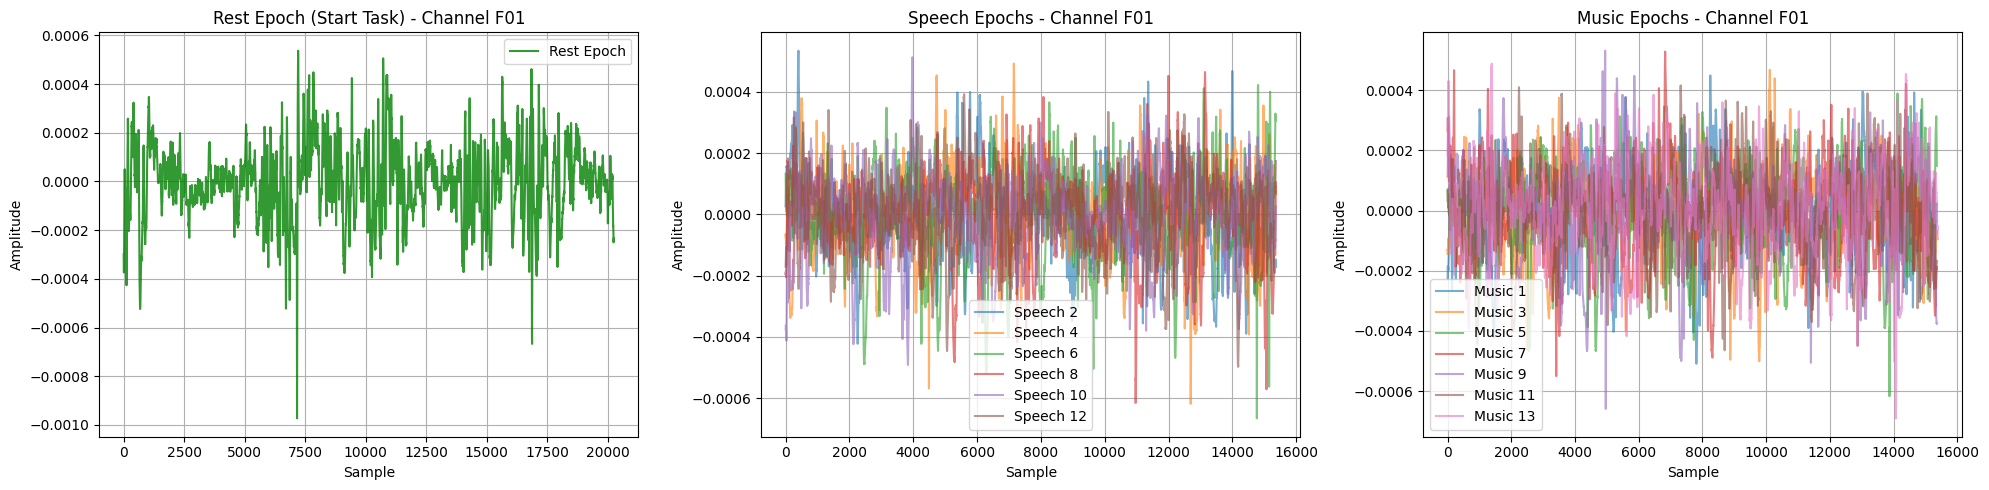

In [4]:
import matplotlib.pyplot as plt

channel_idx = 0
channel_name = electrode_data['names'][channel_idx]

first_event_onset = events_df['onset'].min()
rest_duration = min(first_event_onset, 60)
rest_data = raw.get_data(tmin=0, tmax=rest_duration)

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Rest Epoch
ax0 = axes[0]
ax0.plot(rest_data[channel_idx], alpha=0.8, color='green', label='Rest Epoch')
ax0.set_title(f'Rest Epoch (Start Task) - Channel {channel_name}')
ax0.set_xlabel('Sample')
ax0.set_ylabel('Amplitude')
ax0.legend()
ax0.grid(True)

# Speech Epochs
ax1 = axes[1]
for epoch in speech_epochs:
    ax1.plot(epoch['data'][channel_idx], alpha=0.6, label=f"Speech {epoch['index']}")
ax1.set_title(f'Speech Epochs - Channel {channel_name}')
ax1.set_xlabel('Sample')
ax1.set_ylabel('Amplitude')
ax1.legend()
ax1.grid(True)

# Music Epochs
ax2 = axes[2]
for epoch in music_epochs:
    ax2.plot(epoch['data'][channel_idx], alpha=0.6, label=f"Music {epoch['index']}")
ax2.set_title(f'Music Epochs - Channel {channel_name}')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Amplitude')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Plotting the PSD's for all music and speech epochs of 1 particular channel

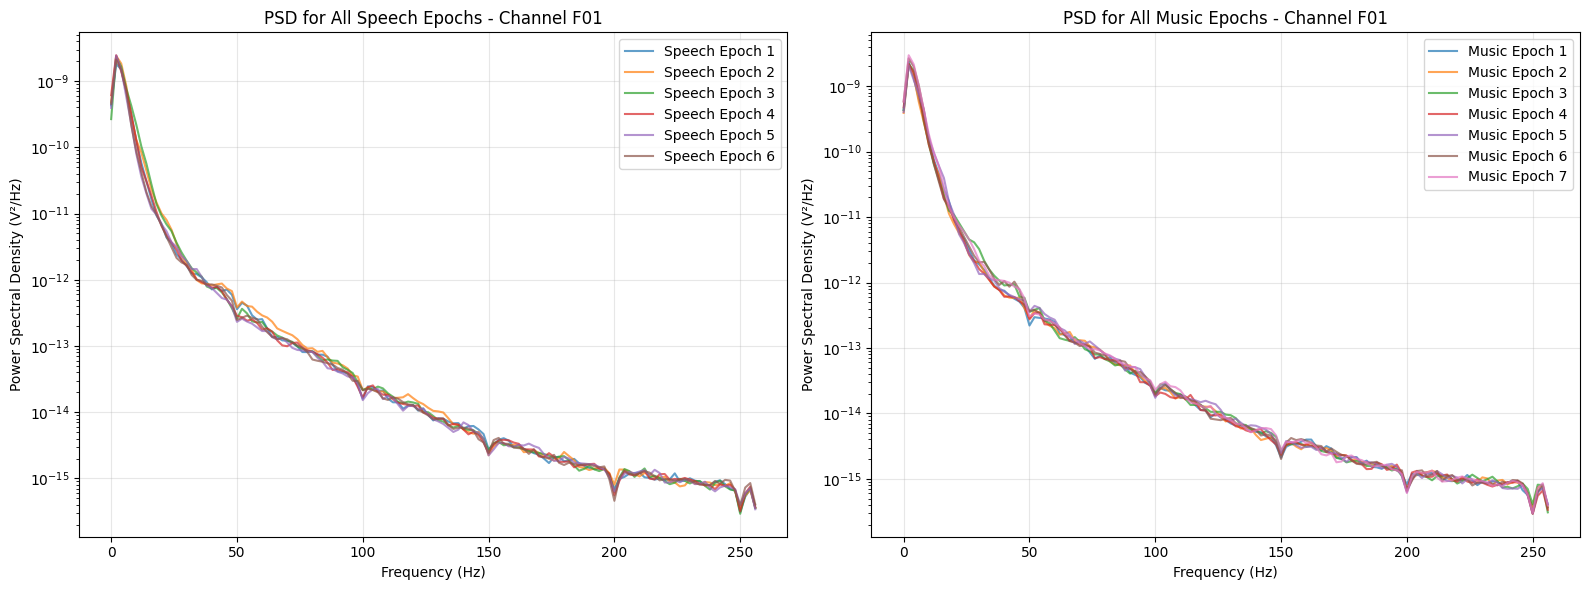

In [5]:
from scipy import signal

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Speech epochs
ax_speech = axes[0]
for i, epoch in enumerate(speech_epochs):
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    ax_speech.semilogy(f, psd, alpha=0.7, linewidth=1.5, label=f"Speech Epoch {i+1}")
ax_speech.set_title(f'PSD for All Speech Epochs - Channel {channel_name}')
ax_speech.set_xlabel('Frequency (Hz)')
ax_speech.set_ylabel('Power Spectral Density (V²/Hz)')
ax_speech.grid(True, alpha=0.3)
ax_speech.legend()

# Music epochs
ax_music = axes[1]
for i, epoch in enumerate(music_epochs):
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    ax_music.semilogy(f, psd, alpha=0.7, linewidth=1.5, label=f"Music Epoch {i+1}")
ax_music.set_title(f'PSD for All Music Epochs - Channel {channel_name}')
ax_music.set_xlabel('Frequency (Hz)')
ax_music.set_ylabel('Power Spectral Density (V²/Hz)')
ax_music.grid(True, alpha=0.3)
ax_music.legend()

plt.tight_layout()
plt.show()

Plotting the average PSD for all speech and music epochs in a particular channel

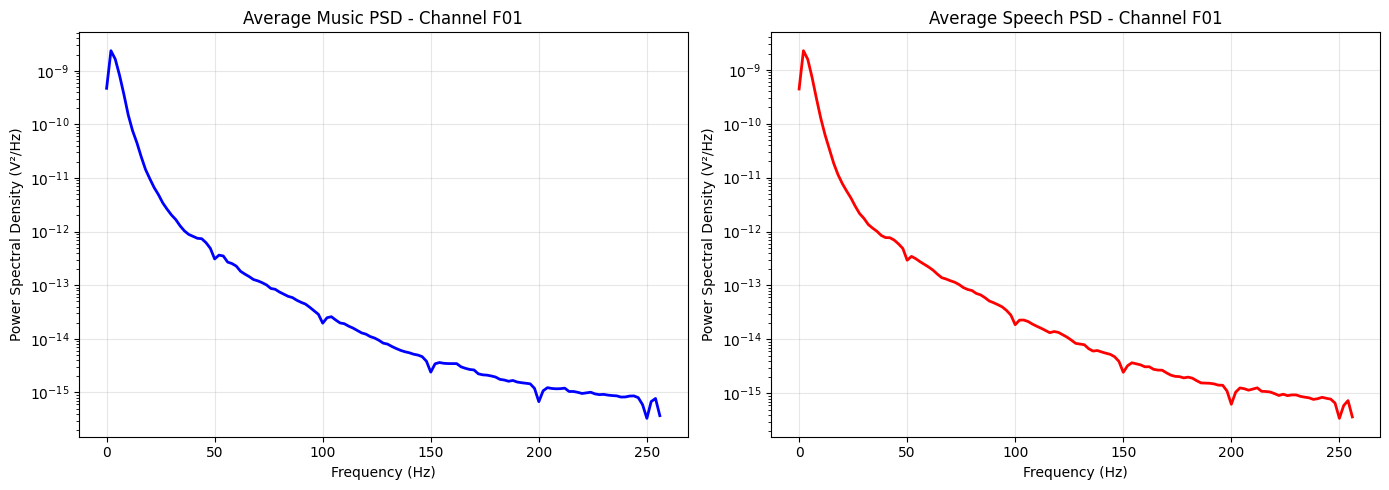

In [6]:
from scipy import signal
music_psd_list = []
speech_psd_list = []

for epoch in music_epochs:
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    music_psd_list.append(psd)

for epoch in speech_epochs:
    f, psd = signal.welch(epoch['data'][channel_idx], sfreq)
    speech_psd_list.append(psd)

music_psd_avg = np.mean(music_psd_list, axis=0)
speech_psd_avg = np.mean(speech_psd_list, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Music PSD
axes[0].semilogy(f, music_psd_avg, linewidth=2, color='blue')
axes[0].set_title(f'Average Music PSD - Channel {channel_name}')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].grid(True, alpha=0.3)

# Speech PSD
axes[1].semilogy(f, speech_psd_avg, linewidth=2, color='red')
axes[1].set_title(f'Average Speech PSD - Channel {channel_name}')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Processing all channels would be computationally expensive. Hence we filter out only the electrodes situated near regions of the brain which processes music and speech and only analyze them. This includes : "HG", "ST", "sT","H", "PT", "ST", "A", "AHL", "AHR", "T", "TOL", "ITR", "vT", "MFL", "MFR", "F"

In [7]:
def get_auditory_picks(raw, electrodes_df):
    available_channels = raw.ch_names
    target_df = electrodes_df[electrodes_df['name'].isin(available_channels)]
    
    auditory_picks = []
    for _, row in target_df.iterrows():
        name = row["name"]
        x, y, z = row["x"], row["y"], row["z"]
        
        is_in_auditory_space = (
            abs(x) >= 35 and 
            -20 <= y <= 20 and 
            -10 <= z <= 25
        )
        is_named_auditory = name.startswith(("HG", "ST", "sT","H", "PT", "ST", "A", "AHL", "AHR", "T", "TOL", "ITR", "vT", "MFL", "MFR", "F"))
        if is_in_auditory_space or (is_named_auditory and abs(x) >= 30):
            auditory_picks.append(name)
    
    return auditory_picks

auditory_channels = get_auditory_picks(raw, electrodes_df)
raw_auditory = raw.copy().pick_channels(auditory_channels)

print(f"Total auditory electrodes selected: {len(auditory_channels)}")
print(f"Selected contacts: {auditory_channels}")

auditory_indices = [i for i, name in enumerate(electrode_data['names']) if name in auditory_channels]
electrode_data_auditory = {
    'coords': electrode_data['coords'][auditory_indices],
    'names': electrode_data['names'][auditory_indices],
    'dataframe': electrode_coords.loc[auditory_channels]
}

print(f"Auditory electrode data updated: {len(auditory_indices)} channels")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Total auditory electrodes selected: 36
Selected contacts: ['F04', 'F05', 'F06', 'F07', 'F08', 'F12', 'F13', 'F14', 'F15', 'F16', 'F19', 'F20', 'F21', 'F22', 'F23', 'F24', 'F27', 'F28', 'F29', 'F30', 'F31', 'F32', 'F34', 'F35', 'F36', 'F37', 'F38', 'F39', 'F40', 'F42', 'F43', 'F44', 'F45', 'F46', 'F47', 'F48']
Auditory electrode data updated: 36 channels


Calculating the Average PSD for all speech epochs and music epochs for all auditory channel and plotting them separately

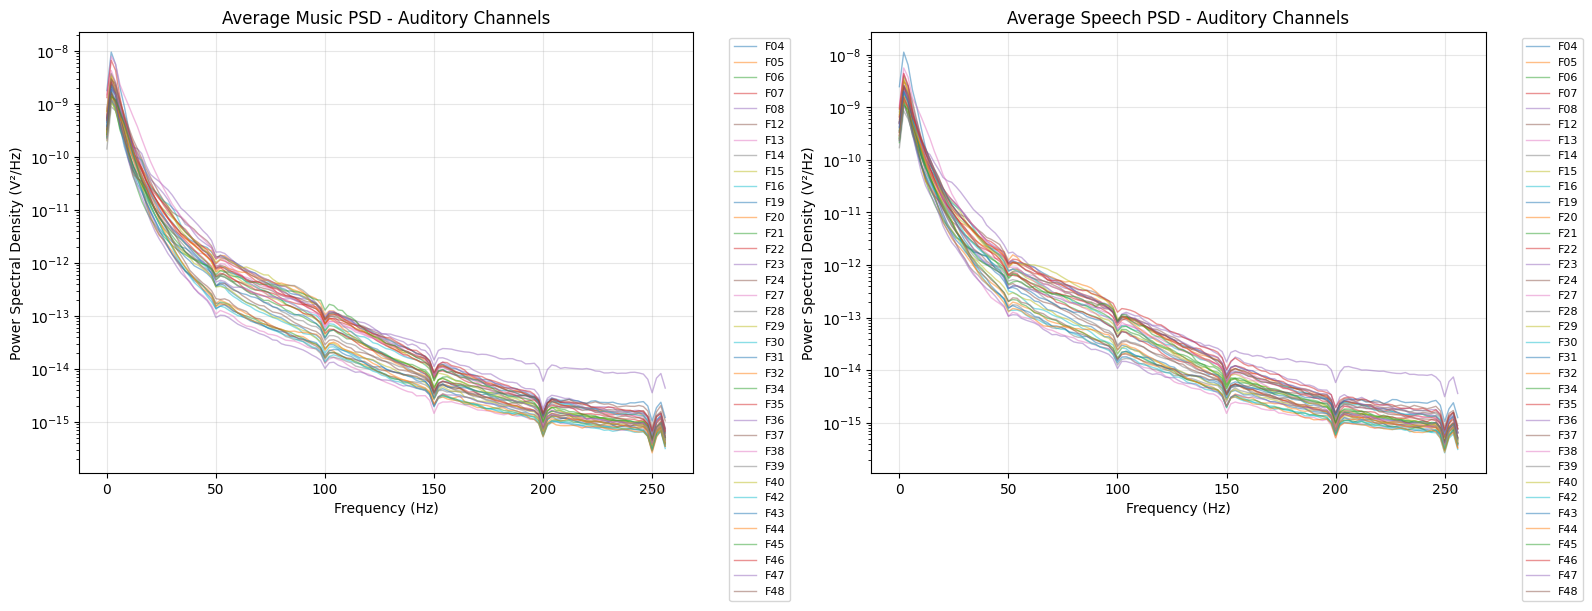

In [8]:
music_psd_auditory = []
speech_psd_auditory = []

for ch_idx in auditory_indices:
    music_psd_ch = []
    speech_psd_ch = []
    
    for epoch in music_epochs:
        ch_name = electrode_data['names'][ch_idx]
        if ch_name in raw.ch_names:
            epoch_ch_idx = raw.ch_names.index(ch_name)
            f, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq)
        else:
            continue
        music_psd_ch.append(psd)
    
    for epoch in speech_epochs:
        ch_name = electrode_data['names'][ch_idx]
        if ch_name in raw.ch_names:
            epoch_ch_idx = raw.ch_names.index(ch_name)
            f, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq)
        else:
            continue
        speech_psd_ch.append(psd)
    
    music_psd_auditory.append(np.mean(music_psd_ch, axis=0))
    speech_psd_auditory.append(np.mean(speech_psd_ch, axis=0))

music_psd_auditory = np.array(music_psd_auditory)
speech_psd_auditory = np.array(speech_psd_auditory)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Music PSD
ax_music = axes[0]
for i, ch_idx in enumerate(auditory_indices):
    ax_music.semilogy(f, music_psd_auditory[i], alpha=0.5, linewidth=1, label=electrode_data['names'][ch_idx])
ax_music.set_title('Average Music PSD - Auditory Channels')
ax_music.set_xlabel('Frequency (Hz)')
ax_music.set_ylabel('Power Spectral Density (V²/Hz)')
ax_music.grid(True, alpha=0.3)
ax_music.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

# Speech PSD
ax_speech = axes[1]
for i, ch_idx in enumerate(auditory_indices):
    ax_speech.semilogy(f, speech_psd_auditory[i], alpha=0.5, linewidth=1, label=electrode_data['names'][ch_idx])
ax_speech.set_title('Average Speech PSD - Auditory Channels')
ax_speech.set_xlabel('Frequency (Hz)')
ax_speech.set_ylabel('Power Spectral Density (V²/Hz)')
ax_speech.grid(True, alpha=0.3)
ax_speech.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

Average PSD of speech and music over all signals

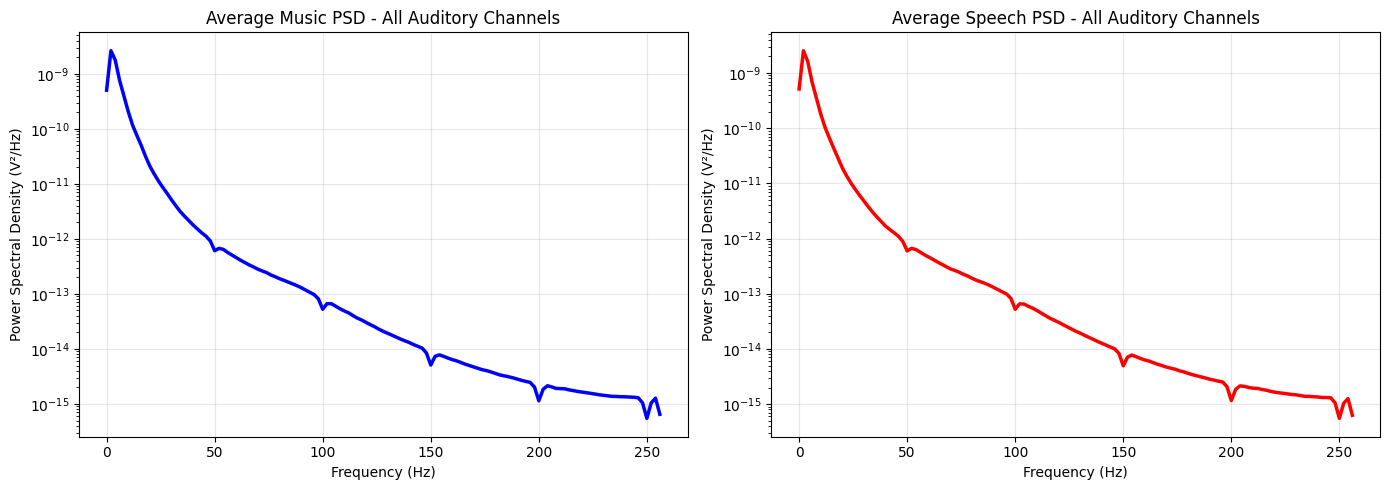

In [9]:

music_psd_avg_auditory = np.mean(music_psd_auditory, axis=0)
speech_psd_avg_auditory = np.mean(speech_psd_auditory, axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Music PSD 
axes[0].semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue')
axes[0].set_title('Average Music PSD - All Auditory Channels')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].grid(True, alpha=0.3)

# Speech PSD 
axes[1].semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red')
axes[1].set_title('Average Speech PSD - All Auditory Channels')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Comparing Rest Data which is provided in a separate .eeg file to show natural brain activity to help with comparison and analysis of affect of music and speech

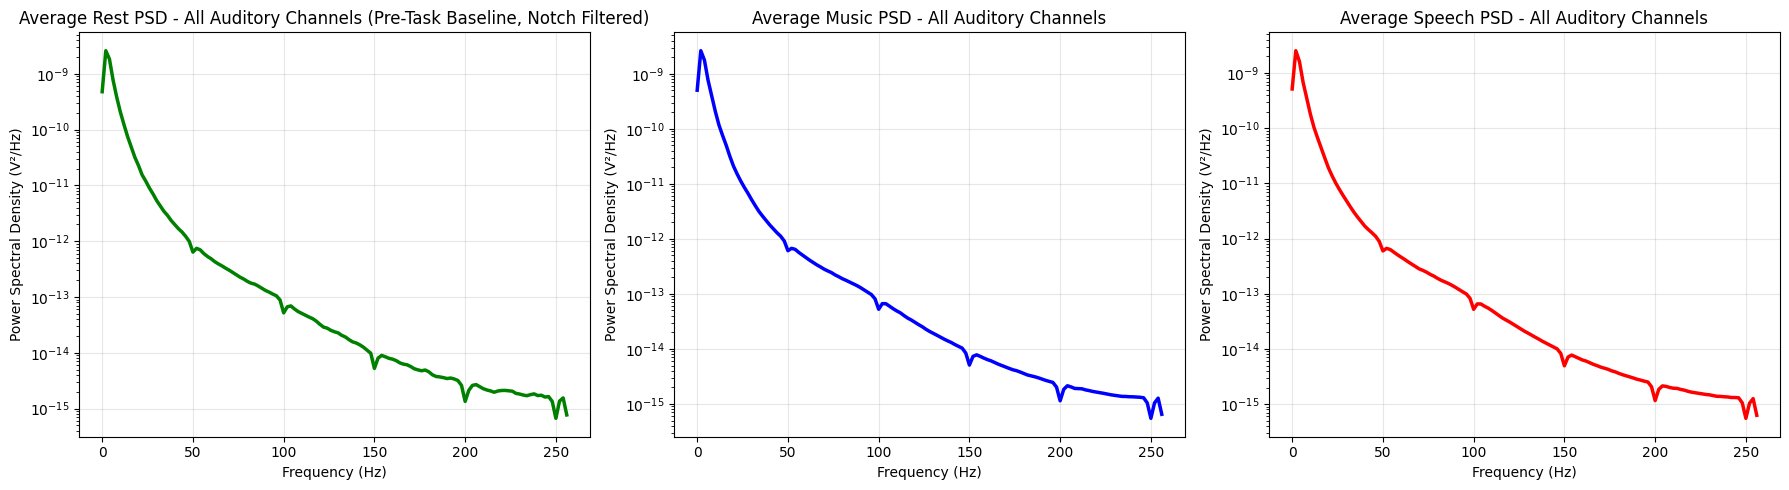

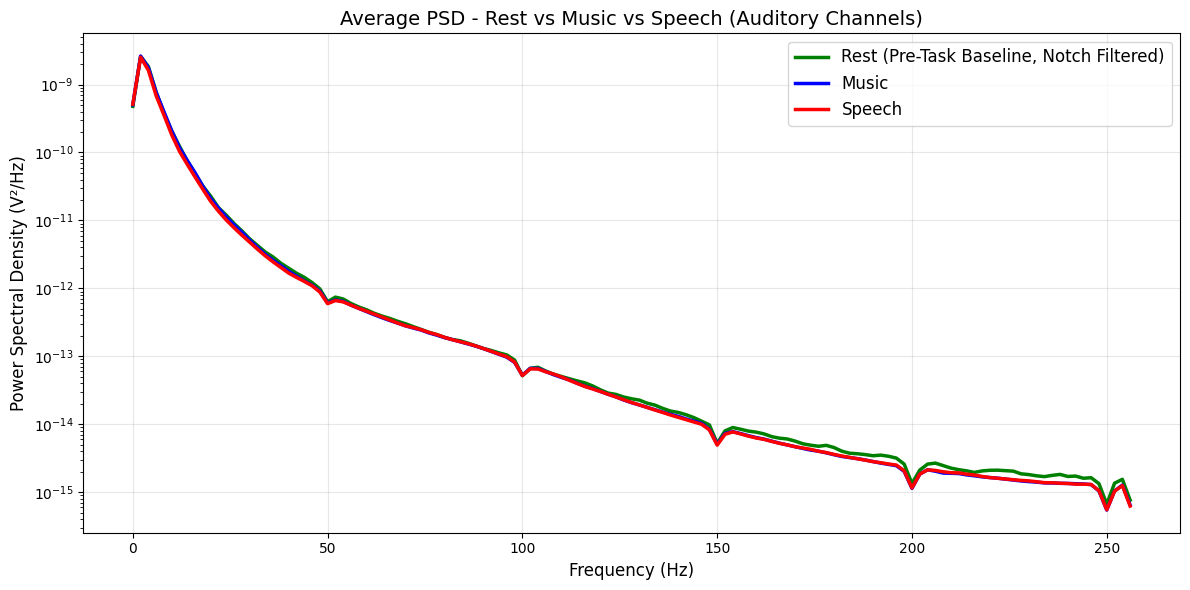

Rest baseline duration: 39.56 seconds


In [10]:

first_event_onset = events_df['onset'].min()
rest_duration = min(first_event_onset, 60)  
rest_raw_film = raw.copy().crop(tmin=0, tmax=rest_duration)

freqs_to_notch = [50, 100, 150, 200, 250]

rest_raw_filtered = rest_raw_film.copy().notch_filter(freqs=freqs_to_notch, verbose=False)

rest_psd_auditory = []

for ch_idx in auditory_indices:
    ch_name = electrode_data['names'][ch_idx]
    if ch_name in rest_raw_filtered.ch_names:
        epoch_ch_idx = rest_raw_filtered.ch_names.index(ch_name)
        f, psd = signal.welch(rest_raw_filtered.get_data()[epoch_ch_idx], sfreq)
        rest_psd_auditory.append(psd)

rest_psd_auditory = np.array(rest_psd_auditory)
rest_psd_avg_auditory = np.mean(rest_psd_auditory, axis=0)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].semilogy(f, rest_psd_avg_auditory, linewidth=2.5, color='green')
axes[0].set_title('Average Rest PSD - All Auditory Channels (Pre-Task Baseline, Notch Filtered)')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].grid(True, alpha=0.3)
axes[1].semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue')
axes[1].set_title('Average Music PSD - All Auditory Channels')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].grid(True, alpha=0.3)

axes[2].semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red')
axes[2].set_title('Average Speech PSD - All Auditory Channels')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Power Spectral Density (V²/Hz)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.semilogy(f, rest_psd_avg_auditory, linewidth=2.5, color='green', label='Rest (Pre-Task Baseline, Notch Filtered)')
ax.semilogy(f, music_psd_avg_auditory, linewidth=2.5, color='blue', label='Music')
ax.semilogy(f, speech_psd_avg_auditory, linewidth=2.5, color='red', label='Speech')
ax.set_title('Average PSD - Rest vs Music vs Speech (Auditory Channels)', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Power Spectral Density (V²/Hz)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

print(f"Rest baseline duration: {rest_duration:.2f} seconds")

/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


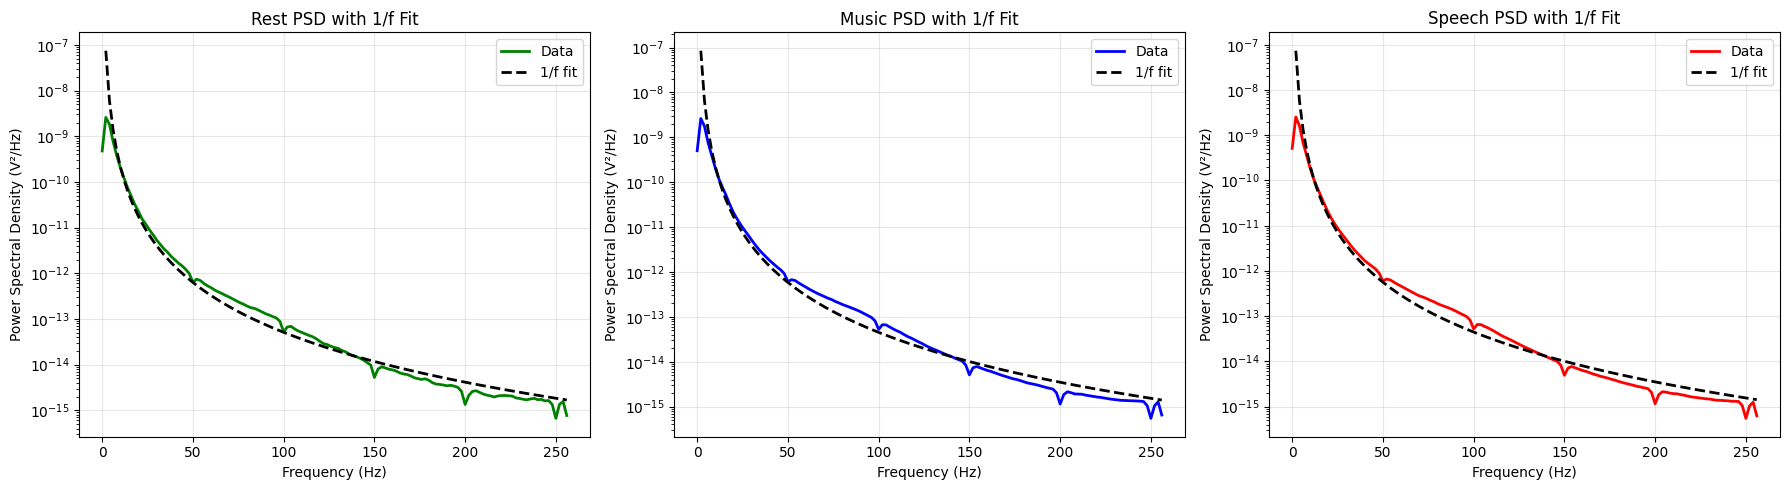

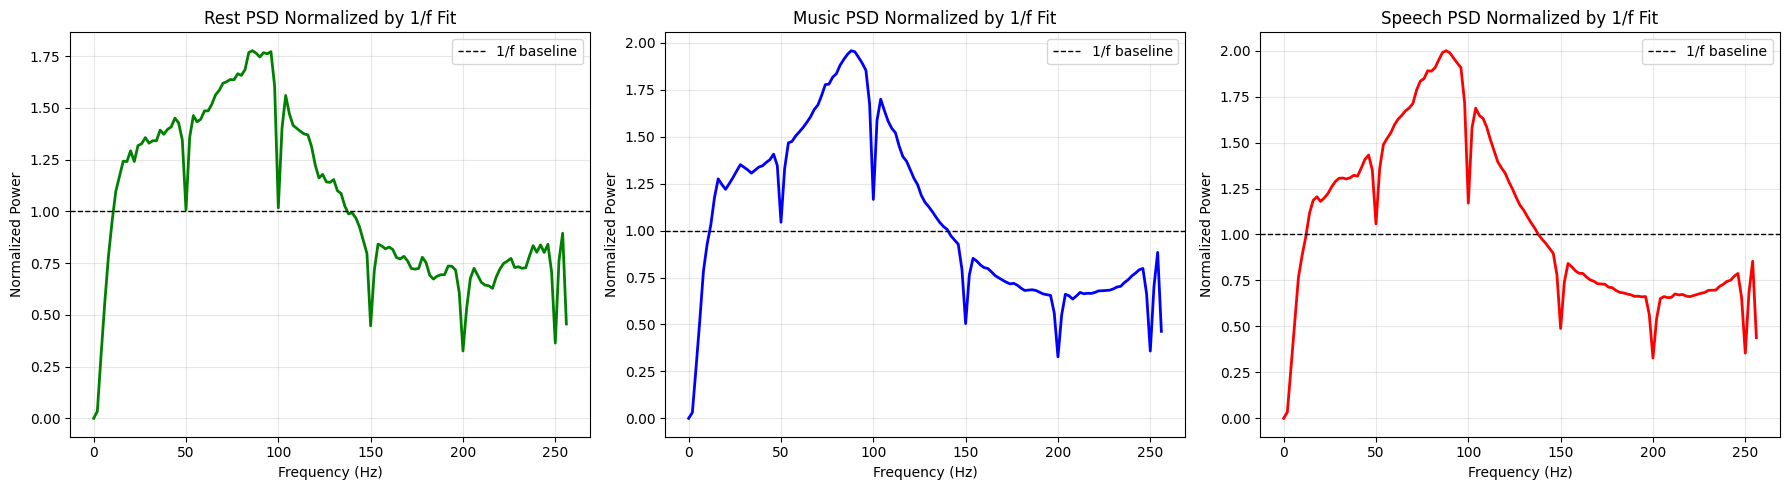

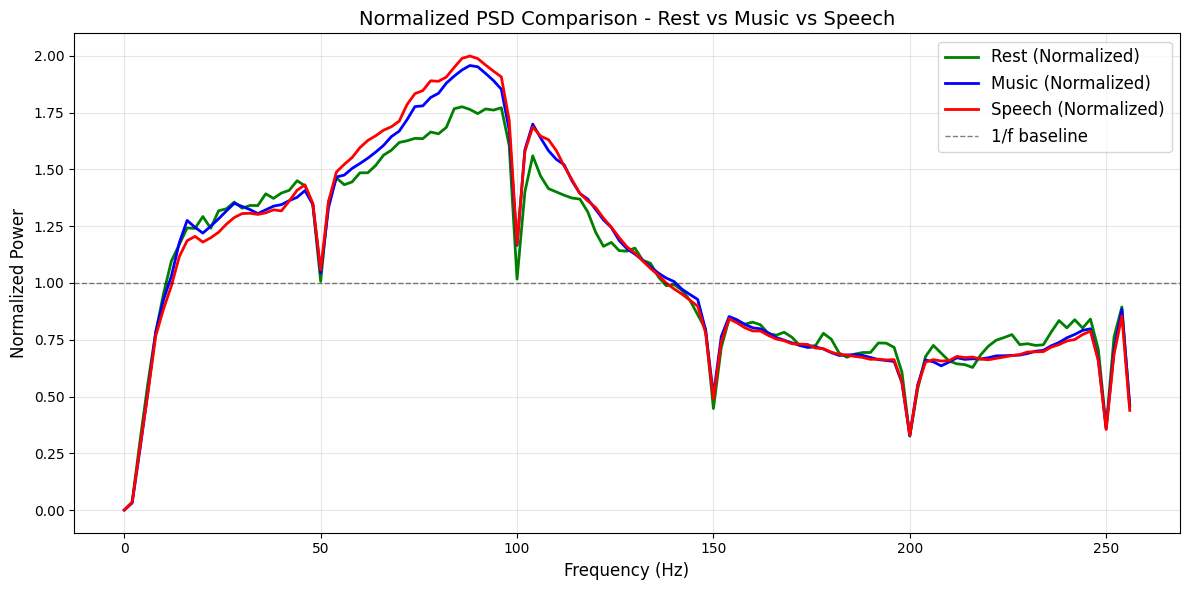

In [11]:
from scipy.optimize import curve_fit

def fit_1overf_robust(freqs, psd, freq_range=(1, 250)):
    """Fits 1/f while ignoring line noise harmonics."""
    if len(freqs) != len(psd):
        raise ValueError(f"Shape mismatch: freqs has {len(freqs)} elements, "
                         f"but psd has {len(psd)} elements.")

    mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    
    for harmonic in [50, 100, 150, 200, 250]:
        mask &= ~((freqs > harmonic - 2) & (freqs < harmonic + 2))
    
    freqs_fit = freqs[mask]
    psd_fit = psd[mask]
    
    def log_model(f, a, b):
        return np.log10(a) - b * np.log10(f)
    
    popt, _ = curve_fit(log_model, freqs_fit, np.log10(psd_fit))
    
    return 10 ** (log_model(freqs, *popt))

f_music, _ = signal.welch(music_epochs[0]['data'][0], sfreq)
f_speech, _ = signal.welch(speech_epochs[0]['data'][0], sfreq)
f_rest, _ = signal.welch(rest_raw_filtered.get_data()[0], sfreq)

rest_1overf = fit_1overf_robust(f_rest, rest_psd_avg_auditory, freq_range=(1, 250))
music_1overf = fit_1overf_robust(f_music, music_psd_avg_auditory, freq_range=(1, 250))
speech_1overf = fit_1overf_robust(f_speech, speech_psd_avg_auditory, freq_range=(1, 250))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rest
axes[0].semilogy(f_rest, rest_psd_avg_auditory, linewidth=2, color='green', label='Data')
axes[0].semilogy(f_rest, rest_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[0].set_title('Rest PSD with 1/f Fit')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power Spectral Density (V²/Hz)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Music
axes[1].semilogy(f_music, music_psd_avg_auditory, linewidth=2, color='blue', label='Data')
axes[1].semilogy(f_music, music_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[1].set_title('Music PSD with 1/f Fit')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Power Spectral Density (V²/Hz)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Speech
axes[2].semilogy(f_speech, speech_psd_avg_auditory, linewidth=2, color='red', label='Data')
axes[2].semilogy(f_speech, speech_1overf, '--', linewidth=2, color='black', label='1/f fit')
axes[2].set_title('Speech PSD with 1/f Fit')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Power Spectral Density (V²/Hz)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

rest_psd_normalized = rest_psd_avg_auditory / rest_1overf
music_psd_normalized = music_psd_avg_auditory / music_1overf
speech_psd_normalized = speech_psd_avg_auditory / speech_1overf

# Plot normalized PSDs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Normalized Rest
axes[0].plot(f_rest, rest_psd_normalized, linewidth=2, color='green')
axes[0].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[0].set_title('Rest PSD Normalized by 1/f Fit')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Normalized Power')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Normalized Music
axes[1].plot(f_music, music_psd_normalized, linewidth=2, color='blue')
axes[1].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[1].set_title('Music PSD Normalized by 1/f Fit')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Power')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Normalized Speech
axes[2].plot(f_speech, speech_psd_normalized, linewidth=2, color='red')
axes[2].axhline(y=1, linestyle='--', color='black', linewidth=1, label='1/f baseline')
axes[2].set_title('Speech PSD Normalized by 1/f Fit')
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Normalized Power')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(f_rest, rest_psd_normalized, linewidth=2, color='green', label='Rest (Normalized)')
ax.plot(f_music, music_psd_normalized, linewidth=2, color='blue', label='Music (Normalized)')
ax.plot(f_speech, speech_psd_normalized, linewidth=2, color='red', label='Speech (Normalized)')
ax.axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
ax.set_title('Normalized PSD Comparison - Rest vs Music vs Speech', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Normalized Power', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
import pickle
import os
from pathlib import Path
import glob

processed_data_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data'
bids_dir = '/home/inesh_roy/iEEG-Analysis/Cogsci_Task/ds003688'

subjects_psd_data = {}
subject_list = ['02', '05', '06', '07', '09','12', '14', '18', '19']

for sub_id in subject_list:
    print(f"\nProcessing Subject {sub_id}...")
    
    try:
        file_path_sub = f'{processed_data_dir}/sub{sub_id}_preprocessed-raw.fif'
        raw_sub = mne.io.read_raw_fif(file_path_sub, preload=True)
        
        bids_path_sub = BIDSPath(subject=sub_id, session='iemu', datatype='ieeg', root=bids_dir)
        electrodes_path_sub = bids_path_sub.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
        electrodes_df_sub = pd.read_csv(electrodes_path_sub.fpath, sep='\t')
        
        pos_sub = {row['name']: [row['x'], row['y'], row['z']] for _, row in electrodes_df_sub.iterrows()}
        montage_sub = mne.channels.make_dig_montage(ch_pos=pos_sub, coord_frame='mri')
        raw_sub.set_montage(montage_sub)
        
        events_df_sub = None
        events_pattern = os.path.join(bids_dir, f'sub-{sub_id}', 'ses-iemu', 'ieeg', 
                                      f'sub-{sub_id}_ses-iemu_task-film_run-*_events.tsv')
        events_files = glob.glob(events_pattern)
        
        if events_files:
            events_file = events_files[0]
            events_df_sub = pd.read_csv(events_file, sep='\t')
            run_num = os.path.basename(events_file).split('run-')[1].split('_')[0]
            print(f"  Found events file with run={run_num}")
        else:
            raise FileNotFoundError(f"No events file found for subject {sub_id}")
        
        sfreq_sub = raw_sub.info['sfreq']
        events_df_sub['sample'] = (events_df_sub['onset'] * sfreq_sub).astype(int)
        
        music_epochs_sub = []
        speech_epochs_sub = []
        for idx, event in events_df_sub.iterrows():
            epoch_data = raw_sub.get_data(tmin=event['onset'], tmax=event['onset'] + event['duration'])
            if event['trial_type'] == 'music':
                music_epochs_sub.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
            elif event['trial_type'] == 'speech':
                speech_epochs_sub.append({'data': epoch_data, 'onset': event['onset'], 'duration': event['duration'], 'index': idx})
        
        auditory_channels_sub = get_auditory_picks(raw_sub, electrodes_df_sub)
        electrode_coords_sub = electrodes_df_sub[['name', 'x', 'y', 'z']].set_index('name')
        electrode_data_sub = {
            'coords': electrodes_df_sub[['x', 'y', 'z']].values,
            'names': electrodes_df_sub['name'].values,
            'dataframe': electrode_coords_sub
        }
        auditory_indices_sub = [i for i, name in enumerate(electrode_data_sub['names']) if name in auditory_channels_sub]
        
        first_event_onset_sub = events_df_sub['onset'].min()
        rest_duration_sub = min(first_event_onset_sub, 60)
        rest_raw_sub = raw_sub.copy().crop(tmin=0, tmax=rest_duration_sub)
        rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)
        
        music_psd_sub = []
        speech_psd_sub = []
        rest_psd_sub = []
        
        for ch_idx in auditory_indices_sub:
            ch_name = electrode_data_sub['names'][ch_idx]
            
            # Music PSD
            music_psd_ch = []
            for epoch in music_epochs_sub:
                if ch_name in raw_sub.ch_names:
                    epoch_ch_idx = raw_sub.ch_names.index(ch_name)
                    f_sub, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq_sub)
                    music_psd_ch.append(psd)
            if music_psd_ch:
                music_psd_sub.append(np.mean(music_psd_ch, axis=0))
            
            # Speech PSD
            speech_psd_ch = []
            for epoch in speech_epochs_sub:
                if ch_name in raw_sub.ch_names:
                    epoch_ch_idx = raw_sub.ch_names.index(ch_name)
                    f_sub, psd = signal.welch(epoch['data'][epoch_ch_idx], sfreq_sub)
                    speech_psd_ch.append(psd)
            if speech_psd_ch:
                speech_psd_sub.append(np.mean(speech_psd_ch, axis=0))
            
            # Rest PSD
            if ch_name in rest_raw_filtered_sub.ch_names:
                epoch_ch_idx = rest_raw_filtered_sub.ch_names.index(ch_name)
                f_sub, psd = signal.welch(rest_raw_filtered_sub.get_data()[epoch_ch_idx], sfreq_sub)
                rest_psd_sub.append(psd)
        
        # Average across channels
        music_psd_avg_sub = np.mean(music_psd_sub, axis=0)
        speech_psd_avg_sub = np.mean(speech_psd_sub, axis=0)
        rest_psd_avg_sub = np.mean(rest_psd_sub, axis=0)
        
        # Normalize
        rest_1overf_sub = fit_1overf_robust(f_sub, rest_psd_avg_sub, freq_range=(1, 250))
        music_1overf_sub = fit_1overf_robust(f_sub, music_psd_avg_sub, freq_range=(1, 250))
        speech_1overf_sub = fit_1overf_robust(f_sub, speech_psd_avg_sub, freq_range=(1, 250))
        
        rest_psd_normalized_sub = rest_psd_avg_sub / rest_1overf_sub
        music_psd_normalized_sub = music_psd_avg_sub / music_1overf_sub
        speech_psd_normalized_sub = speech_psd_avg_sub / speech_1overf_sub
        
        # Store data
        subjects_psd_data[sub_id] = {
            'frequencies': f_sub,
            'rest_psd_raw': rest_psd_avg_sub,
            'music_psd_raw': music_psd_avg_sub,
            'speech_psd_raw': speech_psd_avg_sub,
            'rest_1overf': rest_1overf_sub,
            'music_1overf': music_1overf_sub,
            'speech_1overf': speech_1overf_sub,
            'rest_psd_normalized': rest_psd_normalized_sub,
            'music_psd_normalized': music_psd_normalized_sub,
            'speech_psd_normalized': speech_psd_normalized_sub,
            'auditory_channels': auditory_channels_sub,
            'n_music_epochs': len(music_epochs_sub),
            'n_speech_epochs': len(speech_epochs_sub)
        }
        
        print(f"✓ Subject {sub_id}: {len(auditory_channels_sub)} auditory channels, "
              f"{len(music_epochs_sub)} music epochs, {len(speech_epochs_sub)} speech epochs")
        
    except Exception as e:
        print(f"✗ Error processing Subject {sub_id}: {str(e)}")

os.makedirs(processed_data_dir, exist_ok=True)

output_path = f'{processed_data_dir}/normalized_psd_data.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(subjects_psd_data, f)

print(f"\n✓ Data saved to: {output_path}")
print(f"Total subjects processed: {len(subjects_psd_data)}")


Processing Subject 02...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub02_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 291997 =      0.000 ...   570.307 secs
Ready.
Reading 0 ... 291997  =      0.000 ...   570.307 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 02: 36 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 05...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub05_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 270829 =      0.000 ...   528.963 secs
Ready.
Reading 0 ... 270829  =      0.000 ...   528.963 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 05: 39 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 06...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub06_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 203145 =      0.000 ...   396.768 secs
Ready.
Reading 0 ... 203145  =      0.000 ...   396.768 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1


/tmp/ipykernel_1766/2696112791.py:64: RuntimeWarning: filter_length (3381) is longer than the signal (2705), distortion is likely. Reduce filter length or filter a longer signal.
  rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)


✓ Subject 06: 52 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 07...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub07_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 219614 =      0.000 ...   428.934 secs
Ready.
Reading 0 ... 219614  =      0.000 ...   428.934 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 07: 10 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 09...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub09_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 214220 =      0.000 ...   418.398 secs
Ready.
Reading 0 ... 214220  =      0.000 ...   418.398 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=2
✓ Subject 09: 24 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 12...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub12_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 226269 =      0.000 ...   441.932 secs
Ready.
Reading 0 ... 226269  =      0.000 ...   441.932 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 12: 47 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 14...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub14_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 200895 =      0.000 ...   392.373 secs
Ready.
Reading 0 ... 200895  =      0.000 ...   392.373 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1


/tmp/ipykernel_1766/2696112791.py:64: RuntimeWarning: filter_length (3381) is longer than the signal (635), distortion is likely. Reduce filter length or filter a longer signal.
  rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)


✓ Subject 14: 28 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 18...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub18_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 205452 =      0.000 ...   401.273 secs
Ready.
Reading 0 ... 205452  =      0.000 ...   401.273 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)
/tmp/ipykernel_1766/2696112791.py:64: RuntimeWarning: filter_length (3381) is longer than the signal (3277), distortion is likely. Reduce filter length or filter a longer signal.
  rest_raw_filtered_sub = rest_raw_sub.copy().notch_filter(freqs=[50, 100, 150, 200, 250], verbose=False)


  Found events file with run=1
✓ Subject 18: 52 auditory channels, 7 music epochs, 6 speech epochs

Processing Subject 19...
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub19_preprocessed-raw.fif...


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


Isotrak not found
    Range : 0 ... 210887 =      0.000 ...   411.889 secs
Ready.
Reading 0 ... 210887  =      0.000 ...   411.889 secs...


/tmp/ipykernel_1766/2696112791.py:25: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


  Found events file with run=1
✓ Subject 19: 47 auditory channels, 7 music epochs, 6 speech epochs

✓ Data saved to: /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/normalized_psd_data.pkl
Total subjects processed: 9


/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: invalid value encountered in log10
  return np.log10(a) - b * np.log10(f)
/tmp/ipykernel_1766/2778638225.py:18: RuntimeWarning: divide by zero encountered in log10
  return np.log10(a) - b * np.log10(f)


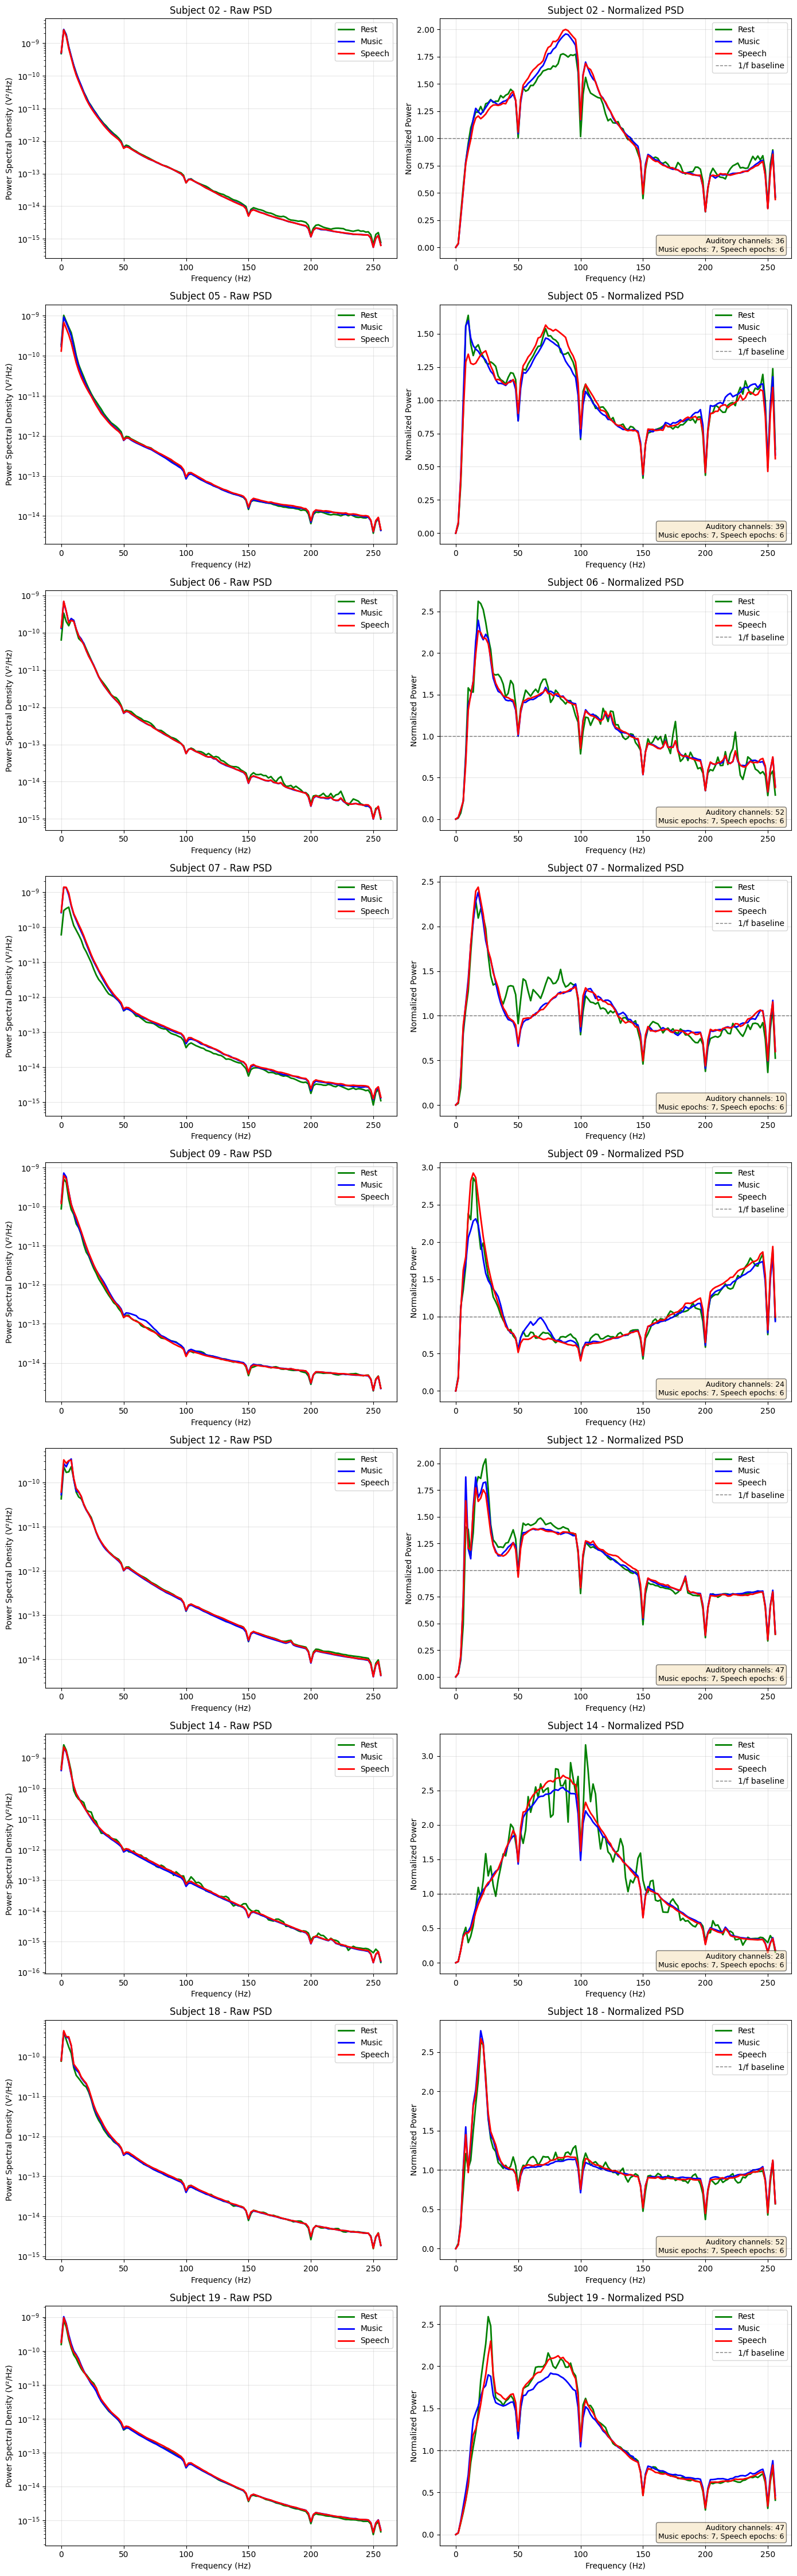

Plotted data for 9 subjects: ['02', '05', '06', '07', '09', '12', '14', '18', '19']


In [13]:
with open(f'{processed_data_dir}/normalized_psd_data.pkl', 'rb') as f:
    subjects_psd_data = pickle.load(f)

n_subjects = len(subjects_psd_data)
fig, axes = plt.subplots(n_subjects, 2, figsize=(14, 5 * n_subjects))


for idx, (sub_id, data) in enumerate(subjects_psd_data.items()):
    f = data['frequencies']
    
    # raw PSDs
    axes[idx, 0].semilogy(f, data['rest_psd_raw'], linewidth=2, color='green', label='Rest')
    axes[idx, 0].semilogy(f, data['music_psd_raw'], linewidth=2, color='blue', label='Music')
    axes[idx, 0].semilogy(f, data['speech_psd_raw'], linewidth=2, color='red', label='Speech')
    axes[idx, 0].set_title(f'Subject {sub_id} - Raw PSD', fontsize=12)
    axes[idx, 0].set_xlabel('Frequency (Hz)')
    axes[idx, 0].set_ylabel('Power Spectral Density (V²/Hz)')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Normalized PSDs
    axes[idx, 1].plot(f, data['rest_psd_normalized'], linewidth=2, color='green', label='Rest')
    axes[idx, 1].plot(f, data['music_psd_normalized'], linewidth=2, color='blue', label='Music')
    axes[idx, 1].plot(f, data['speech_psd_normalized'], linewidth=2, color='red', label='Speech')
    axes[idx, 1].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
    axes[idx, 1].set_title(f'Subject {sub_id} - Normalized PSD', fontsize=12)
    axes[idx, 1].set_xlabel('Frequency (Hz)')
    axes[idx, 1].set_ylabel('Normalized Power')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)
    
    info_text = f"Auditory channels: {len(data['auditory_channels'])}\n"
    info_text += f"Music epochs: {data['n_music_epochs']}, Speech epochs: {data['n_speech_epochs']}"
    axes[idx, 1].text(0.98, 0.02, info_text, transform=axes[idx, 1].transAxes,
                     fontsize=9, verticalalignment='bottom', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print(f"Plotted data for {n_subjects} subjects: {list(subjects_psd_data.keys())}")


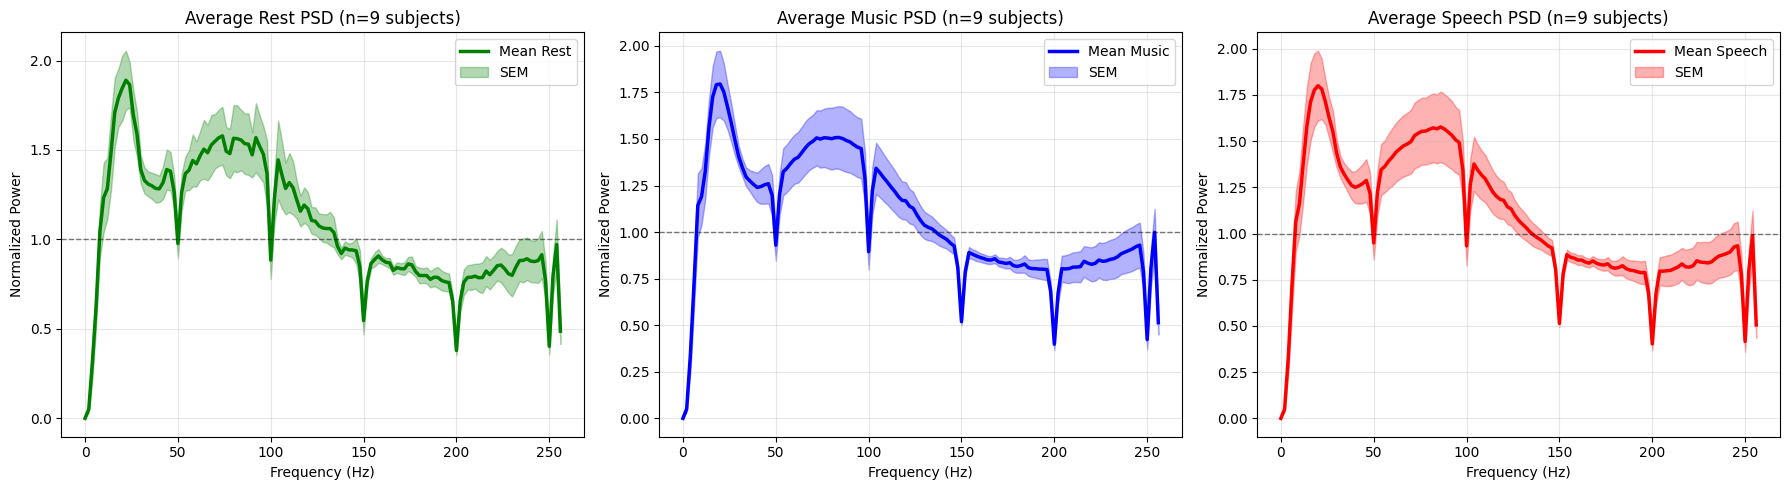

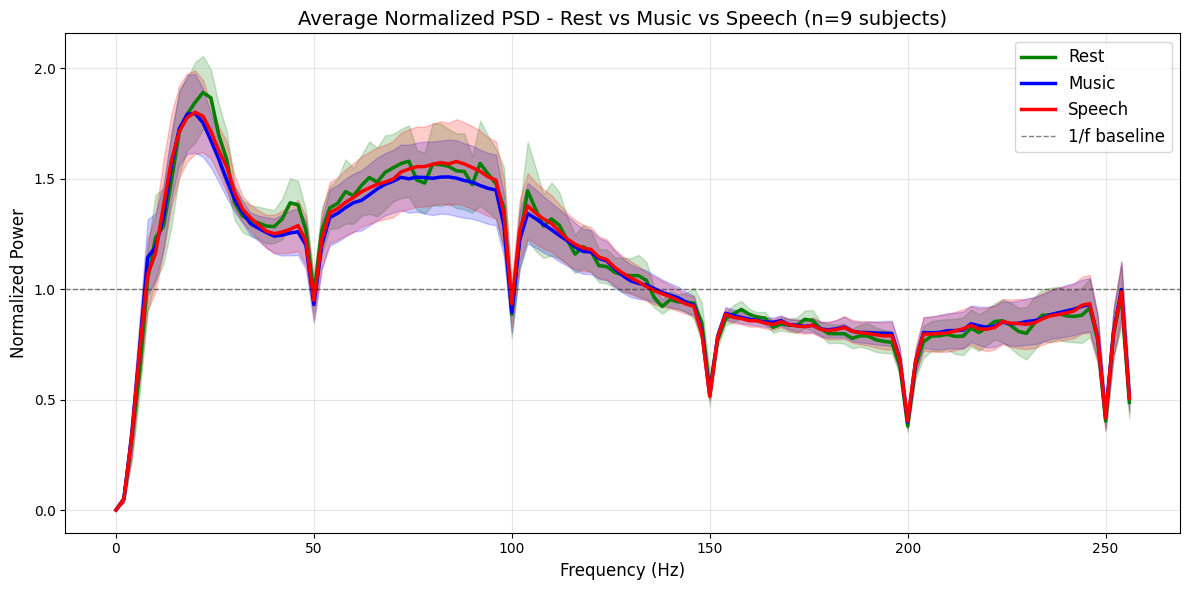

Average PSDs calculated across 9 subjects
Subjects: ['02', '05', '06', '07', '09', '12', '14', '18', '19']


In [14]:
n_subjects = len(subjects_psd_data)

all_rest_psd = []
all_music_psd = []
all_speech_psd = []

for sub_id, data in subjects_psd_data.items():
    all_rest_psd.append(data['rest_psd_normalized'])
    all_music_psd.append(data['music_psd_normalized'])
    all_speech_psd.append(data['speech_psd_normalized'])

all_rest_psd = np.array(all_rest_psd)
all_music_psd = np.array(all_music_psd)
all_speech_psd = np.array(all_speech_psd)

rest_psd_mean = np.mean(all_rest_psd, axis=0)
music_psd_mean = np.mean(all_music_psd, axis=0)
speech_psd_mean = np.mean(all_speech_psd, axis=0)

rest_psd_sem = np.std(all_rest_psd, axis=0) / np.sqrt(n_subjects)
music_psd_sem = np.std(all_music_psd, axis=0) / np.sqrt(n_subjects)
speech_psd_sem = np.std(all_speech_psd, axis=0) / np.sqrt(n_subjects)

f_avg = subjects_psd_data['02']['frequencies']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Rest PSD with error cloud
axes[0].plot(f_avg, rest_psd_mean, linewidth=2.5, color='green', label='Mean Rest')
axes[0].fill_between(f_avg, rest_psd_mean - rest_psd_sem, rest_psd_mean + rest_psd_sem, 
                      alpha=0.3, color='green', label='SEM')
axes[0].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[0].set_title(f'Average Rest PSD (n={n_subjects} subjects)', fontsize=12)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Normalized Power')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Music PSD with error cloud
axes[1].plot(f_avg, music_psd_mean, linewidth=2.5, color='blue', label='Mean Music')
axes[1].fill_between(f_avg, music_psd_mean - music_psd_sem, music_psd_mean + music_psd_sem, 
                      alpha=0.3, color='blue', label='SEM')
axes[1].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[1].set_title(f'Average Music PSD (n={n_subjects} subjects)', fontsize=12)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Normalized Power')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Speech PSD with error cloud
axes[2].plot(f_avg, speech_psd_mean, linewidth=2.5, color='red', label='Mean Speech')
axes[2].fill_between(f_avg, speech_psd_mean - speech_psd_sem, speech_psd_mean + speech_psd_sem, 
                      alpha=0.3, color='red', label='SEM')
axes[2].axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5)
axes[2].set_title(f'Average Speech PSD (n={n_subjects} subjects)', fontsize=12)
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Normalized Power')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(f_avg, rest_psd_mean, linewidth=2.5, color='green', label='Rest')
ax.fill_between(f_avg, rest_psd_mean - rest_psd_sem, rest_psd_mean + rest_psd_sem, 
                alpha=0.2, color='green')

ax.plot(f_avg, music_psd_mean, linewidth=2.5, color='blue', label='Music')
ax.fill_between(f_avg, music_psd_mean - music_psd_sem, music_psd_mean + music_psd_sem, 
                alpha=0.2, color='blue')

ax.plot(f_avg, speech_psd_mean, linewidth=2.5, color='red', label='Speech')
ax.fill_between(f_avg, speech_psd_mean - speech_psd_sem, speech_psd_mean + speech_psd_sem, 
                alpha=0.2, color='red')

ax.axhline(y=1, linestyle='--', color='black', linewidth=1, alpha=0.5, label='1/f baseline')
ax.set_title(f'Average Normalized PSD - Rest vs Music vs Speech (n={n_subjects} subjects)', fontsize=14)
ax.set_xlabel('Frequency (Hz)', fontsize=12)
ax.set_ylabel('Normalized Power', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average PSDs calculated across {n_subjects} subjects")
print(f"Subjects: {list(subjects_psd_data.keys())}")

Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub02_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 291997 =      0.000 ...   570.307 secs
Ready.
Reading 0 ... 291997  =      0.000 ...   570.307 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


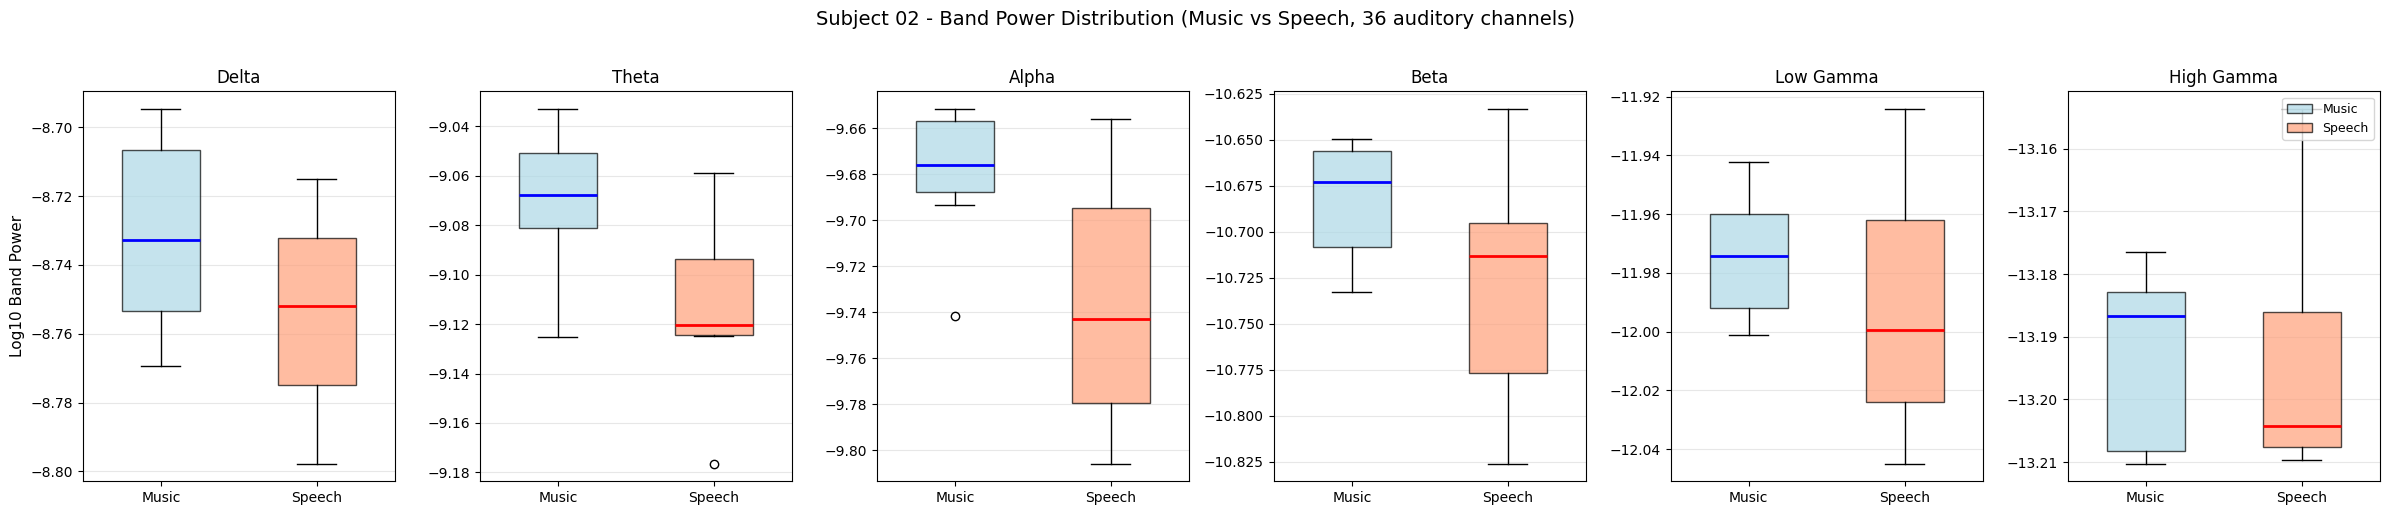

✓ Subject 02 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub05_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 270829 =      0.000 ...   528.963 secs
Ready.
Reading 0 ... 270829  =      0.000 ...   528.963 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


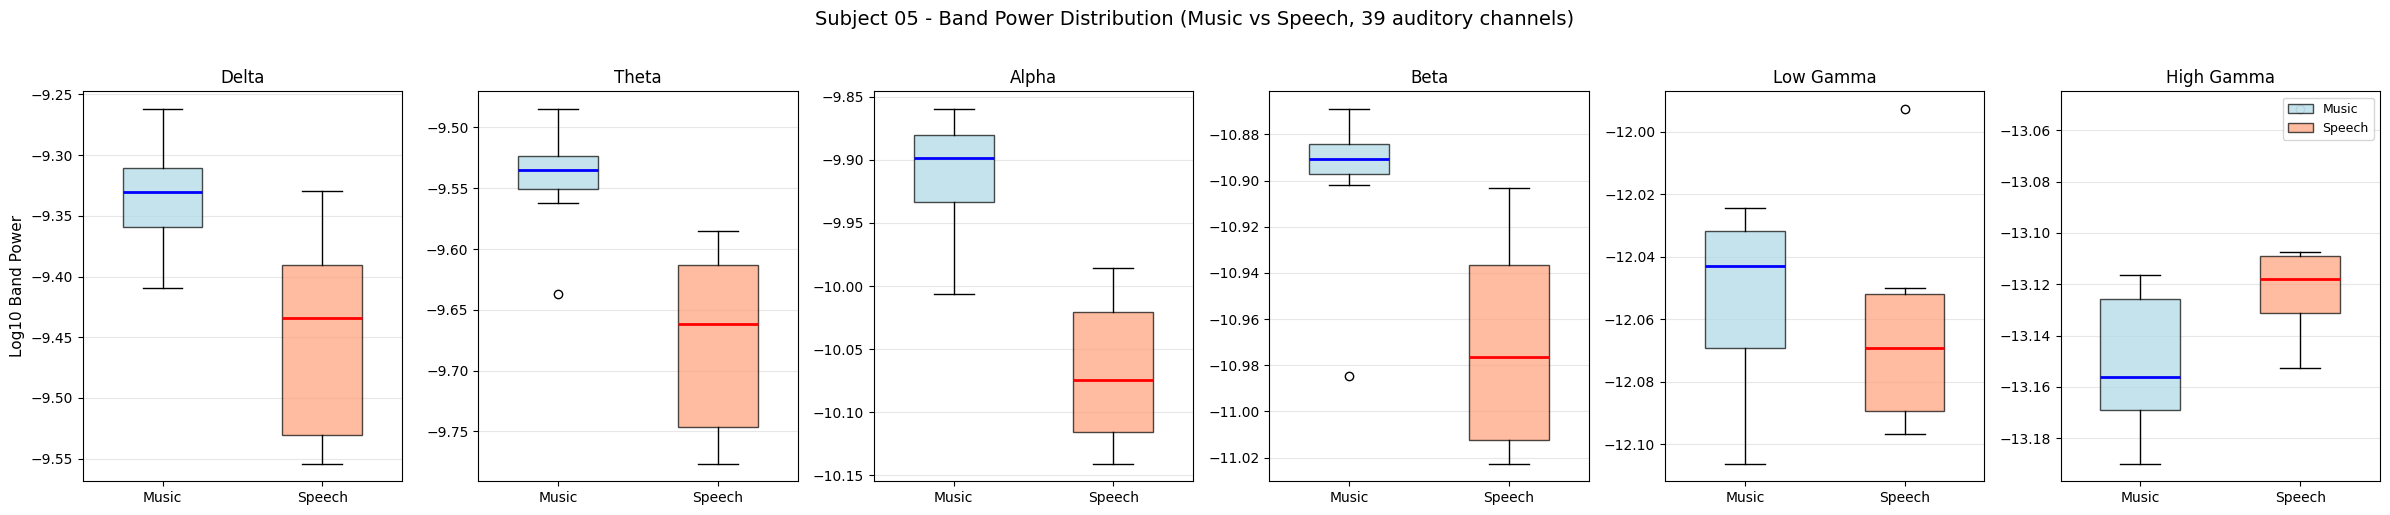

✓ Subject 05 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub06_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 203145 =      0.000 ...   396.768 secs
Ready.
Reading 0 ... 203145  =      0.000 ...   396.768 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


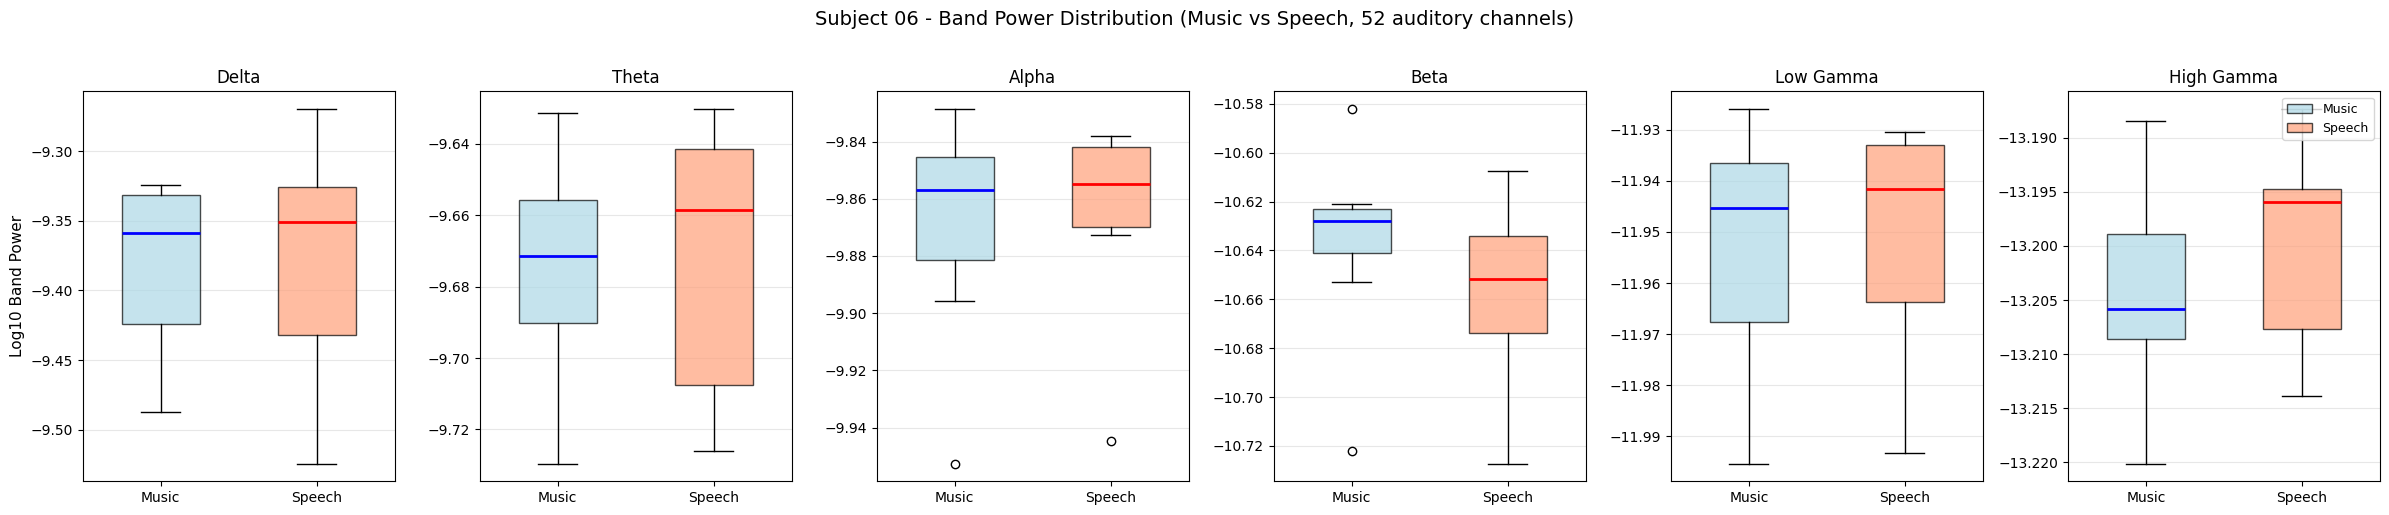

✓ Subject 06 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub07_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 219614 =      0.000 ...   428.934 secs
Ready.
Reading 0 ... 219614  =      0.000 ...   428.934 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


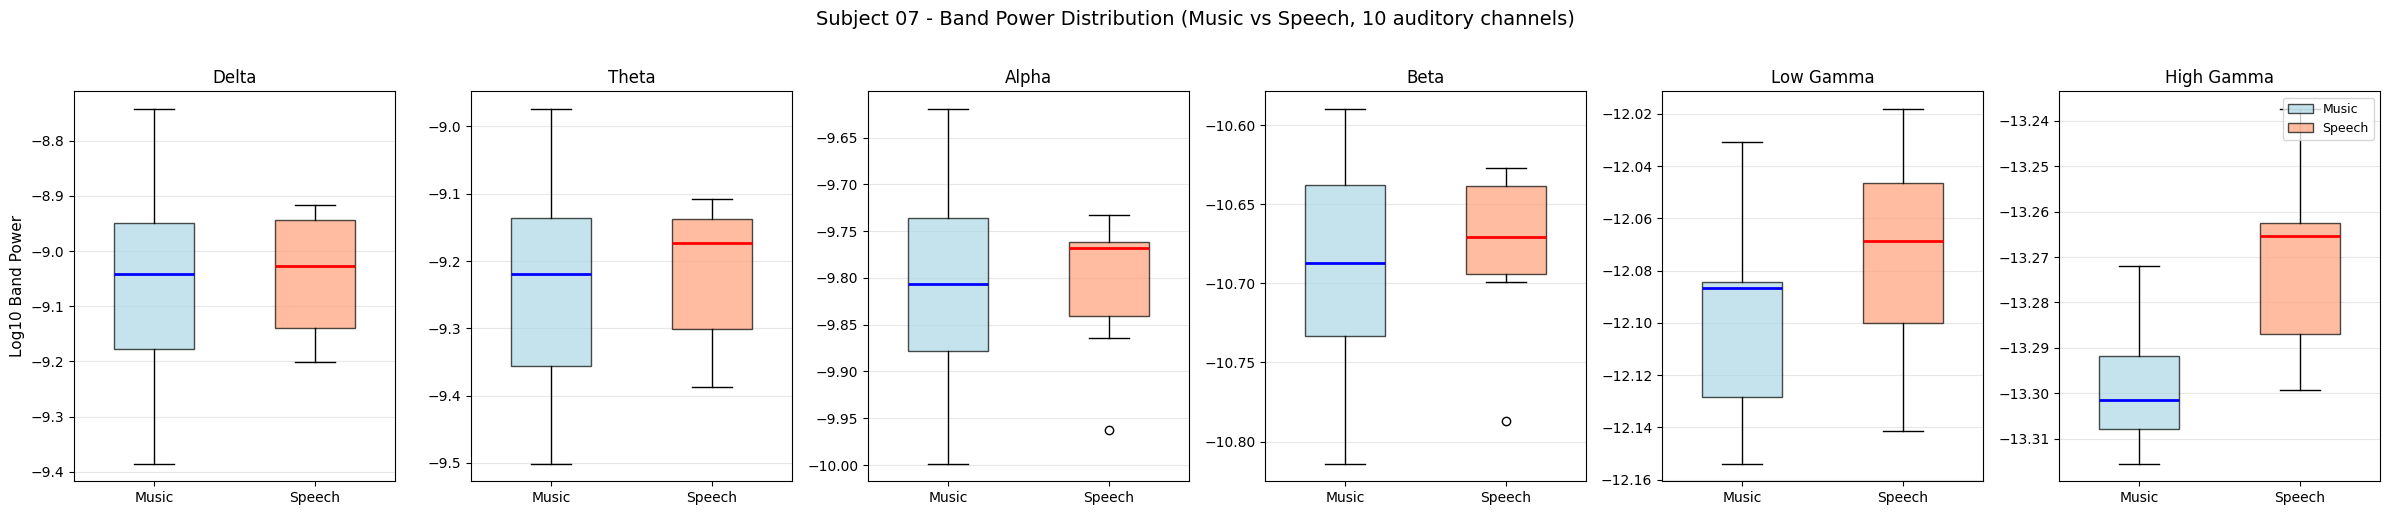

✓ Subject 07 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub09_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 214220 =      0.000 ...   418.398 secs
Ready.
Reading 0 ... 214220  =      0.000 ...   418.398 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


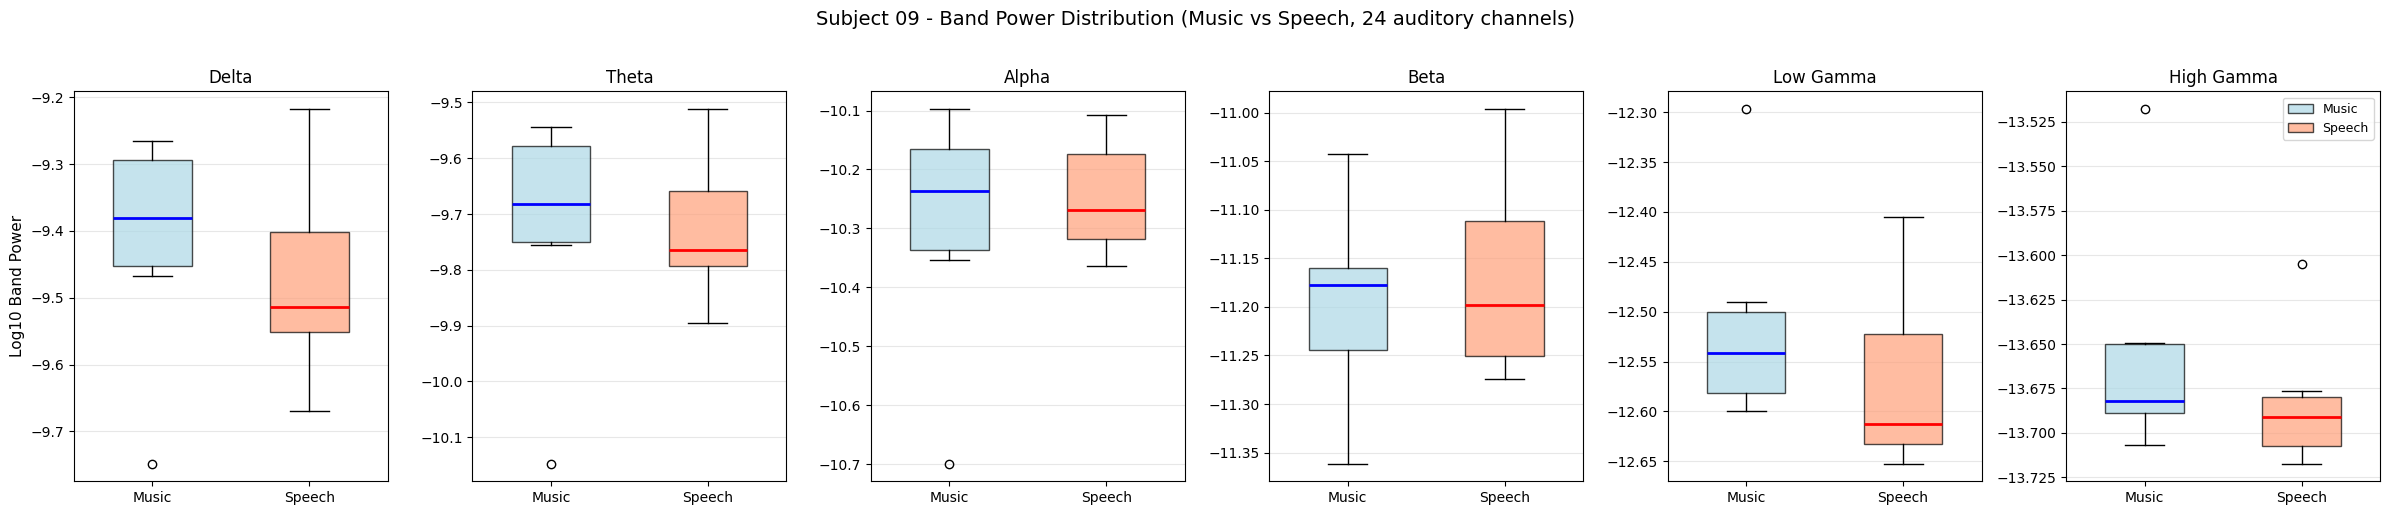

✓ Subject 09 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub12_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 226269 =      0.000 ...   441.932 secs
Ready.
Reading 0 ... 226269  =      0.000 ...   441.932 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


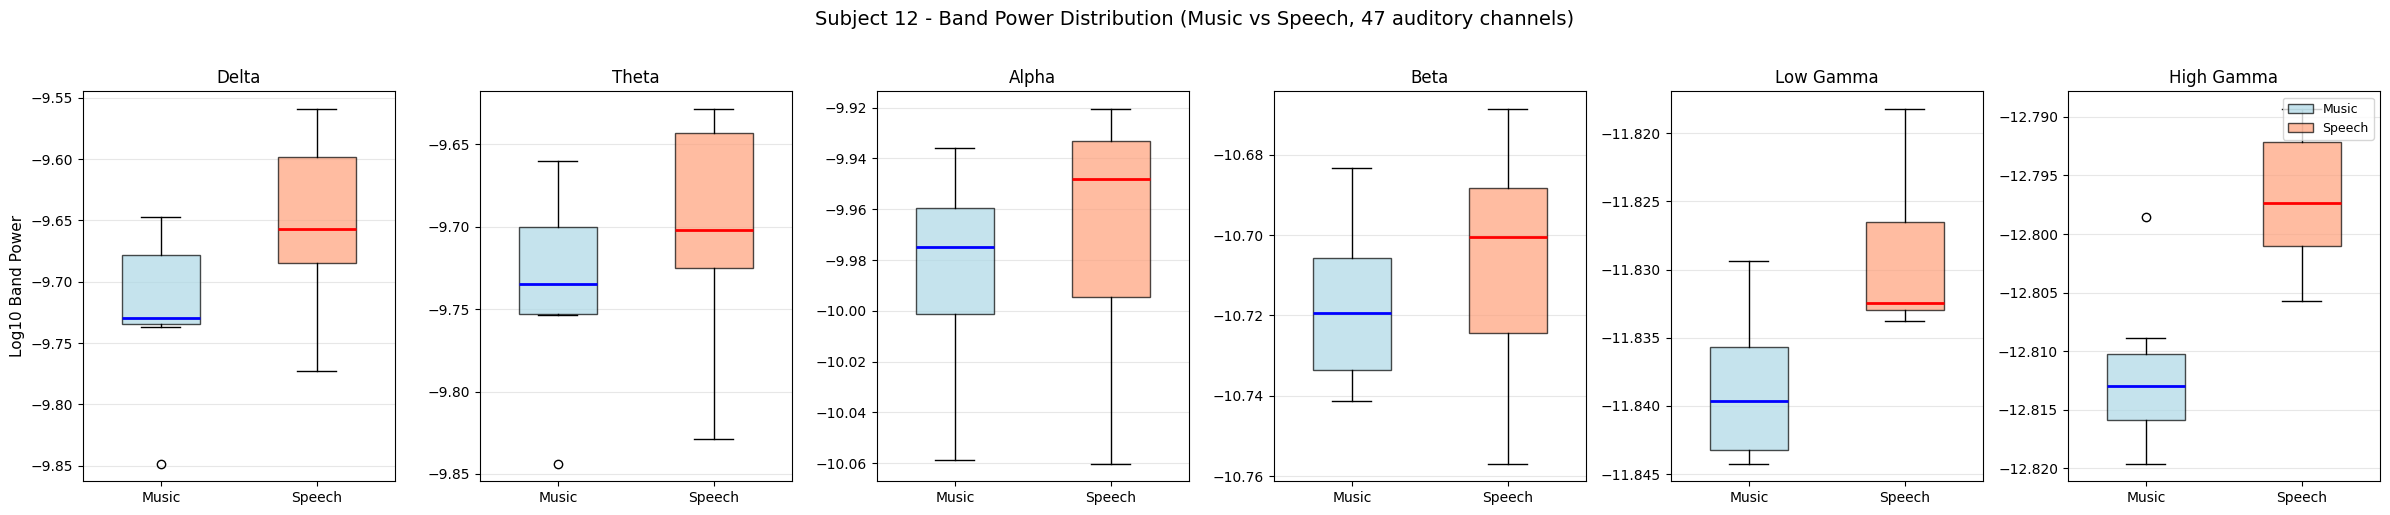

✓ Subject 12 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub14_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 200895 =      0.000 ...   392.373 secs
Ready.
Reading 0 ... 200895  =      0.000 ...   392.373 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


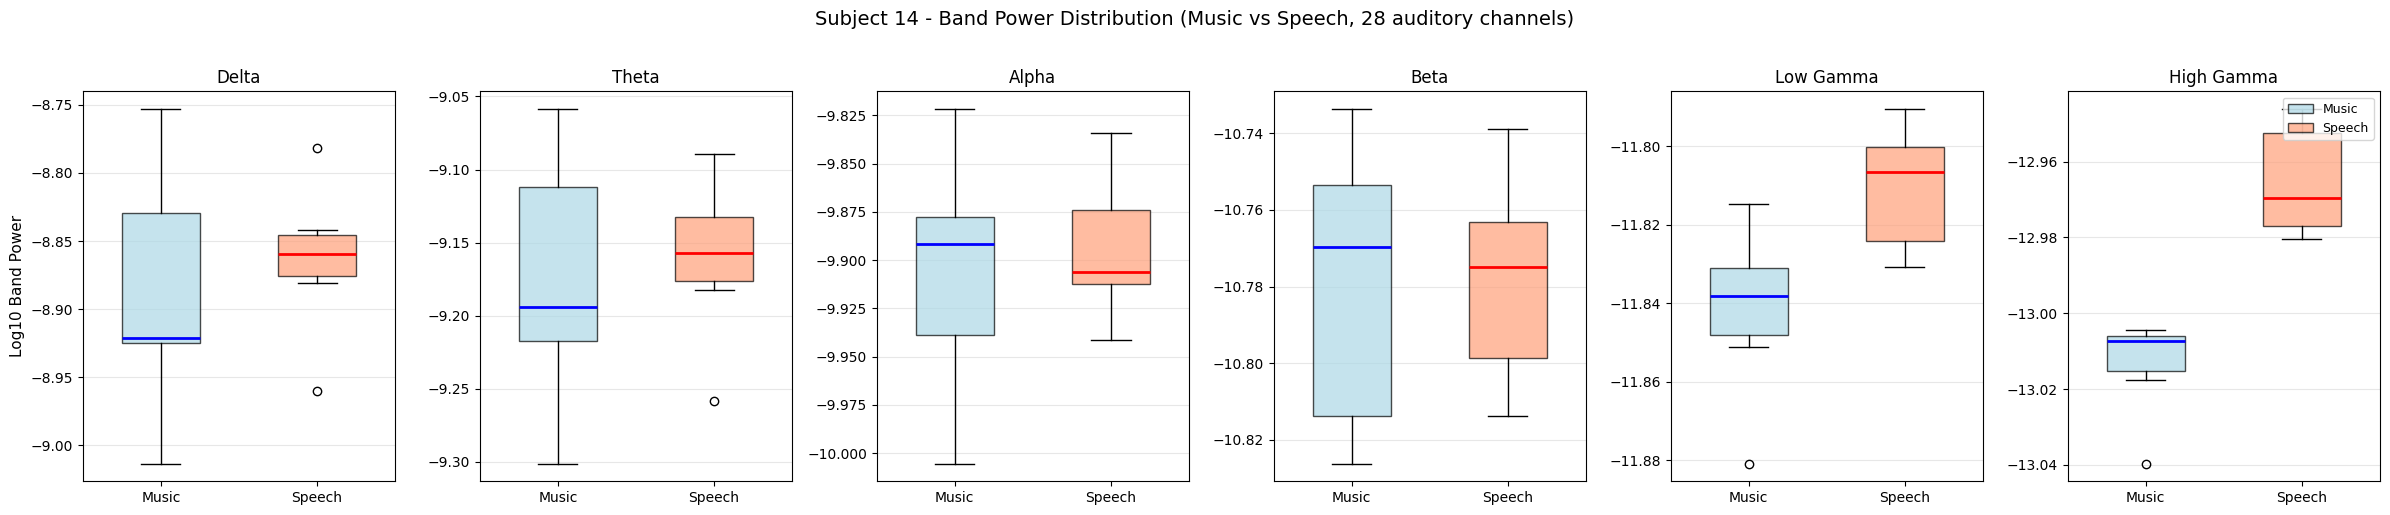

✓ Subject 14 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub18_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 205452 =      0.000 ...   401.273 secs
Ready.
Reading 0 ... 205452  =      0.000 ...   401.273 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


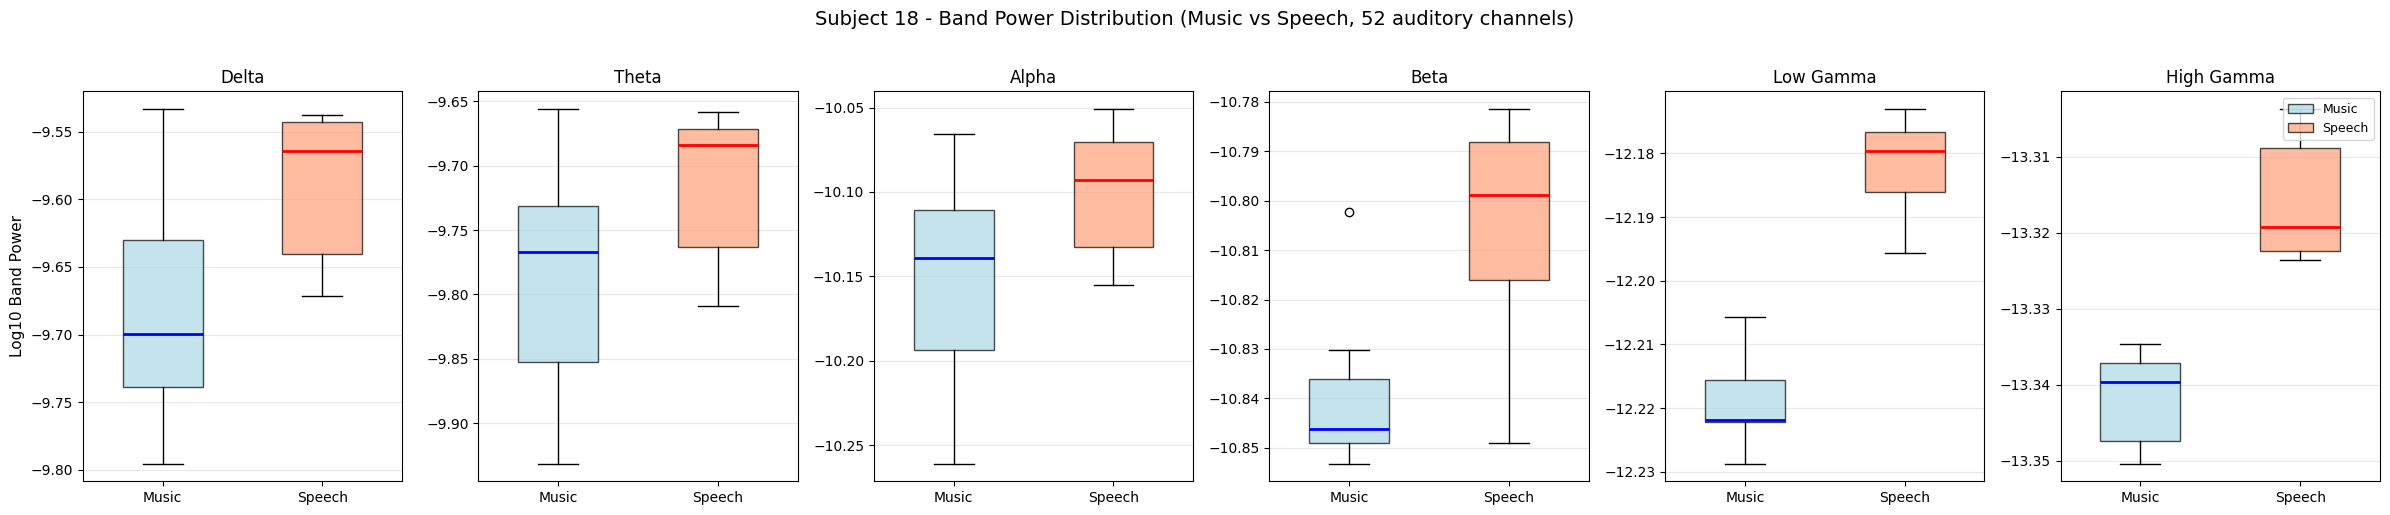

✓ Subject 18 plotted
Opening raw data file /home/inesh_roy/iEEG-Analysis/Cogsci_Task/processed_data/sub19_preprocessed-raw.fif...
Isotrak not found
    Range : 0 ... 210887 =      0.000 ...   411.889 secs
Ready.
Reading 0 ... 210887  =      0.000 ...   411.889 secs...


/tmp/ipykernel_15039/2863051314.py:36: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  raw_sub.set_montage(montage_sub)


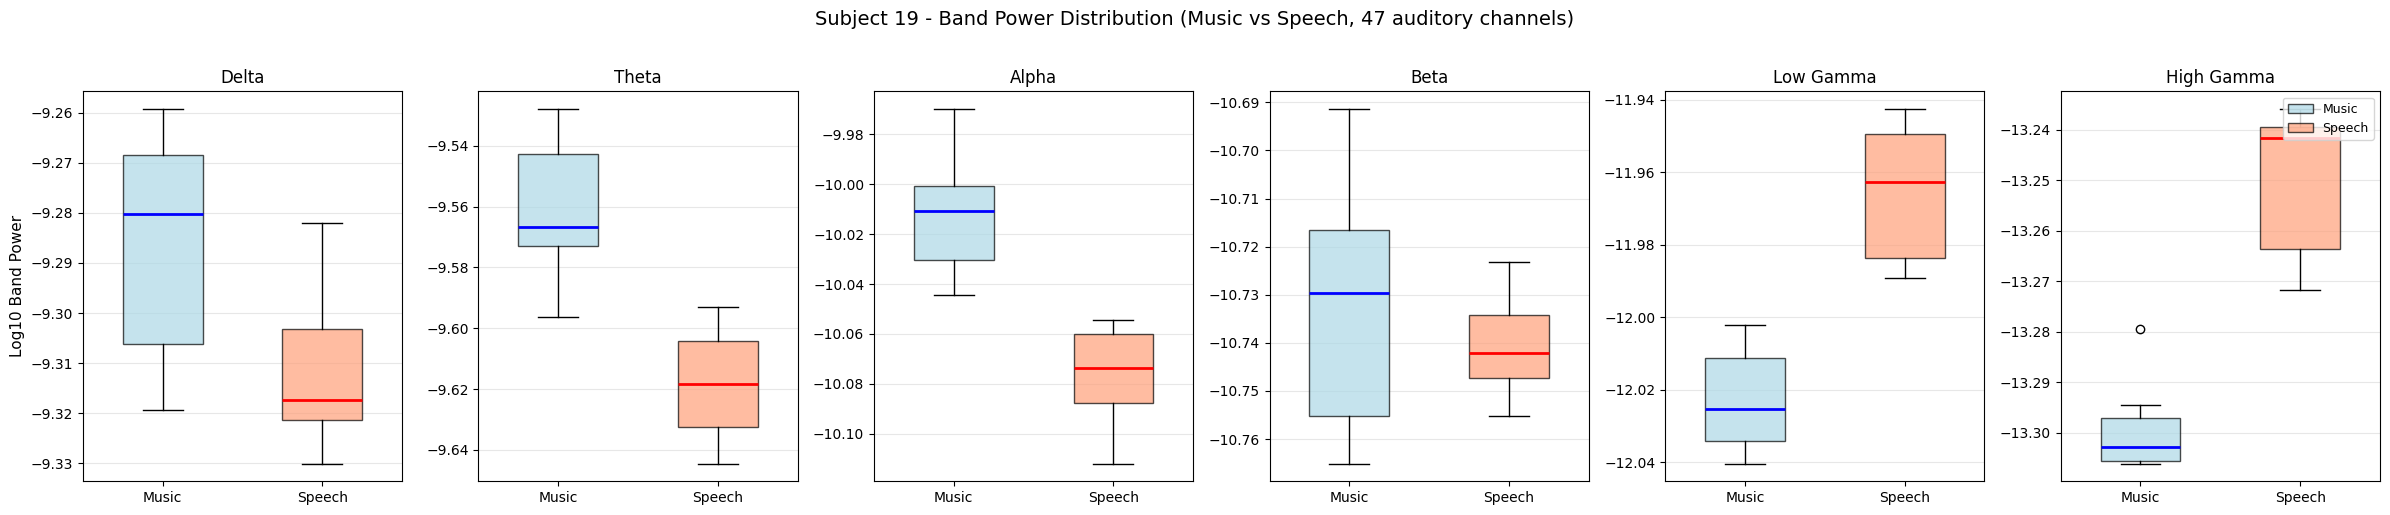

✓ Subject 19 plotted


In [15]:
# Define frequency bands and band names
bands = {
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Low Gamma (30-70 Hz)': (30, 70),
    'High Gamma (70-150 Hz)': (70, 150)
}
band_names_list = list(bands.keys())

for sub_idx, sub_id in enumerate(subject_list):
    if sub_id not in subjects_psd_data:
        continue
    
    data = subjects_psd_data[sub_id]
    f = data['frequencies']
    
    # Compute band power for each epoch for this subject
    band_data_music = {b: [] for b in bands}
    band_data_speech = {b: [] for b in bands}
    
    # Get auditory channel indices for this subject
    aud_chs = data['auditory_channels']
    
    # Reload subject data to get per-epoch PSDs
    file_path_sub = f'{processed_data_dir}/sub{sub_id}_preprocessed-raw.fif'
    raw_sub = mne.io.read_raw_fif(file_path_sub, preload=True)
    
    bids_path_sub = BIDSPath(subject=sub_id, session='iemu', datatype='ieeg', root=bids_dir)
    electrodes_path_sub = bids_path_sub.copy().update(suffix='electrodes', extension='.tsv', acquisition='clinical')
    electrodes_df_sub = pd.read_csv(electrodes_path_sub.fpath, sep='\t')
    
    pos_sub = {row['name']: [row['x'], row['y'], row['z']] for _, row in electrodes_df_sub.iterrows()}
    montage_sub = mne.channels.make_dig_montage(ch_pos=pos_sub, coord_frame='mri')
    raw_sub.set_montage(montage_sub)
    
    events_pattern = os.path.join(bids_dir, f'sub-{sub_id}', 'ses-iemu', 'ieeg',
                                  f'sub-{sub_id}_ses-iemu_task-film_run-*_events.tsv')
    events_files = glob.glob(events_pattern)
    events_df_sub = pd.read_csv(events_files[0], sep='\t')
    
    sfreq_sub = raw_sub.info['sfreq']
    
    music_epochs_sub = []
    speech_epochs_sub = []
    for idx_ev, event in events_df_sub.iterrows():
        epoch_data = raw_sub.get_data(tmin=event['onset'], tmax=event['onset'] + event['duration'])
        if event['trial_type'] == 'music':
            music_epochs_sub.append(epoch_data)
        elif event['trial_type'] == 'speech':
            speech_epochs_sub.append(epoch_data)
    
    aud_chs_sub = get_auditory_picks(raw_sub, electrodes_df_sub)
    aud_indices_sub = [raw_sub.ch_names.index(ch) for ch in aud_chs_sub if ch in raw_sub.ch_names]
    
    # Compute per-epoch band power (averaged across auditory channels)
    for band_name, (fmin, fmax) in bands.items():
        for ep_data in music_epochs_sub:
            bp_vals = []
            for ch_idx_a in aud_indices_sub:
                f_w, psd_w = signal.welch(ep_data[ch_idx_a], sfreq_sub)
                band_mask = (f_w >= fmin) & (f_w <= fmax)
                bp_vals.append(np.log10(np.mean(psd_w[band_mask]) + 1e-30))
            band_data_music[band_name].append(np.mean(bp_vals))
        
        for ep_data in speech_epochs_sub:
            bp_vals = []
            for ch_idx_a in aud_indices_sub:
                f_w, psd_w = signal.welch(ep_data[ch_idx_a], sfreq_sub)
                band_mask = (f_w >= fmin) & (f_w <= fmax)
                bp_vals.append(np.log10(np.mean(psd_w[band_mask]) + 1e-30))
            band_data_speech[band_name].append(np.mean(bp_vals))
    
    # Plot each band on its own panel for this subject
    n_b = len(band_names_list)
    fig, axes_bands = plt.subplots(1, n_b, figsize=(4 * n_b, 5), sharey=False)
    fig.suptitle(f'Subject {sub_id} - Band Power Distribution (Music vs Speech, {len(aud_chs_sub)} auditory channels)',
                 fontsize=14, y=1.02)
    
    for b_idx, band_name in enumerate(band_names_list):
        ax = axes_bands[b_idx]
        band_short = band_name.split(' (')[0]
        
        bp_music = ax.boxplot([band_data_music[band_name]],
                              positions=[0], widths=0.5, patch_artist=True,
                              boxprops=dict(facecolor='lightblue', alpha=0.7),
                              medianprops=dict(color='blue', linewidth=2))
        bp_speech = ax.boxplot([band_data_speech[band_name]],
                               positions=[1], widths=0.5, patch_artist=True,
                               boxprops=dict(facecolor='lightsalmon', alpha=0.7),
                               medianprops=dict(color='red', linewidth=2))
        
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Music', 'Speech'], fontsize=10)
        ax.set_title(band_short, fontsize=12)
        if b_idx == 0:
            ax.set_ylabel('Log10 Band Power', fontsize=11)
        ax.grid(True, alpha=0.3, axis='y')
        
        if b_idx == n_b - 1:
            ax.legend([bp_music["boxes"][0], bp_speech["boxes"][0]], ['Music', 'Speech'],
                      fontsize=9, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    del raw_sub
    print(f"✓ Subject {sub_id} plotted")


Checking which frequency range does music dominate over speech in

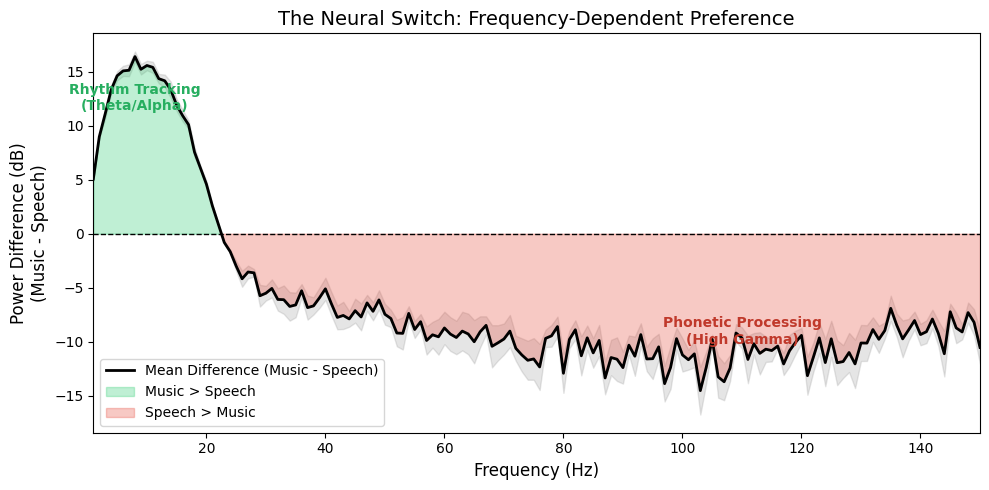

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem


def prepare_data(data_dict):
    """Extracts and normalizes data for plotting."""
    # Frequencies (assuming same for all subjects)
    first_sub = list(data_dict.keys())[0]
    freqs = data_dict[first_sub]['frequencies']
    
    # Store processed difference curves
    diff_curves = [] # (Music - Speech)
    
    # Store Band Power for Bar Plots
    # Low Freq: 4-12 Hz (Theta/Alpha)
    # High Freq: 70-150 Hz (High Gamma)
    low_band_idx = (freqs >= 4) & (freqs <= 12)
    high_band_idx = (freqs >= 70) & (freqs <= 150)
    
    roi_data = {
        'low_music': [], 'low_speech': [],
        'high_music': [], 'high_speech': []
    }
    
    for sub in data_dict:
        # Use Log Power to normalize 1/f magnitude differences
        P_m = 10 * np.log10(data_dict[sub]['music_psd_raw'])
        P_s = 10 * np.log10(data_dict[sub]['speech_psd_raw'])
        
        # 1. Curve: Music - Speech
        diff_curves.append(P_m - P_s)
        
        # 2. ROI Means
        roi_data['low_music'].append(np.mean(P_m[low_band_idx]))
        roi_data['low_speech'].append(np.mean(P_s[low_band_idx]))
        roi_data['high_music'].append(np.mean(P_m[high_band_idx]))
        roi_data['high_speech'].append(np.mean(P_s[high_band_idx]))
        
    return freqs, np.array(diff_curves), roi_data

freqs, diff_curves_arr, roi_data = prepare_data(subjects_psd_data)

def plot_difference_spectrum(freqs, diff_curves):
    mean_diff = np.mean(diff_curves, axis=0)
    sem_diff = sem(diff_curves, axis=0)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    # Plot Mean Line
    ax.plot(freqs, mean_diff, color='k', lw=2, label='Mean Difference (Music - Speech)')
    
    # Shade Standard Error
    ax.fill_between(freqs, mean_diff-sem_diff, mean_diff+sem_diff, color='gray', alpha=0.2)
    
    # Shade "Music Preference" (Positive) in Green/Blue
    ax.fill_between(freqs, mean_diff, 0, where=(mean_diff > 0), 
                    interpolate=True, color='#2ecc71', alpha=0.3, label='Music > Speech')
    
    # Shade "Speech Preference" (Negative) in Red/Orange
    ax.fill_between(freqs, mean_diff, 0, where=(mean_diff < 0), 
                    interpolate=True, color='#e74c3c', alpha=0.3, label='Speech > Music')
    
    ax.axhline(0, color='k', linestyle='--', lw=1)
    
    # Annotations
    ax.text(8, np.max(mean_diff)*0.7, "Rhythm Tracking\n(Theta/Alpha)", 
            color='#27ae60', ha='center', fontweight='bold')
    ax.text(110, np.min(mean_diff)*0.7, "Phonetic Processing\n(High Gamma)", 
            color='#c0392b', ha='center', fontweight='bold')
    
    ax.set_title("The Neural Switch: Frequency-Dependent Preference", fontsize=14)
    ax.set_xlabel("Frequency (Hz)", fontsize=12)
    ax.set_ylabel("Power Difference (dB)\n(Music - Speech)", fontsize=12)
    ax.legend(loc='lower left')
    ax.set_xlim(1, 150)
    plt.tight_layout()
    plt.show()

plot_difference_spectrum(freqs, diff_curves_arr)


FREQUENCY BAND PREFERENCES: Music - Speech (dB)
Positive values = Music preference | Negative values = Speech preference
         Delta (1-4 Hz)  Theta (4-8 Hz)  Alpha (8-13 Hz)  Beta (13-30 Hz)  \
Subject                                                                     
02                0.276           0.462            0.545            0.466   
05                1.325           1.506            1.497            0.500   
06               -0.092           0.170            0.258            0.093   
07               -0.082          -0.354           -0.318           -0.448   
09                0.563           0.221           -0.315           -0.317   
12               -0.806          -0.229           -0.198           -0.083   
14               -0.316          -0.284           -0.167           -0.154   
18               -0.214          -0.197           -0.383           -0.332   
19                0.302           0.520            0.477           -0.233   

         Low Gamma (30-70 Hz)  

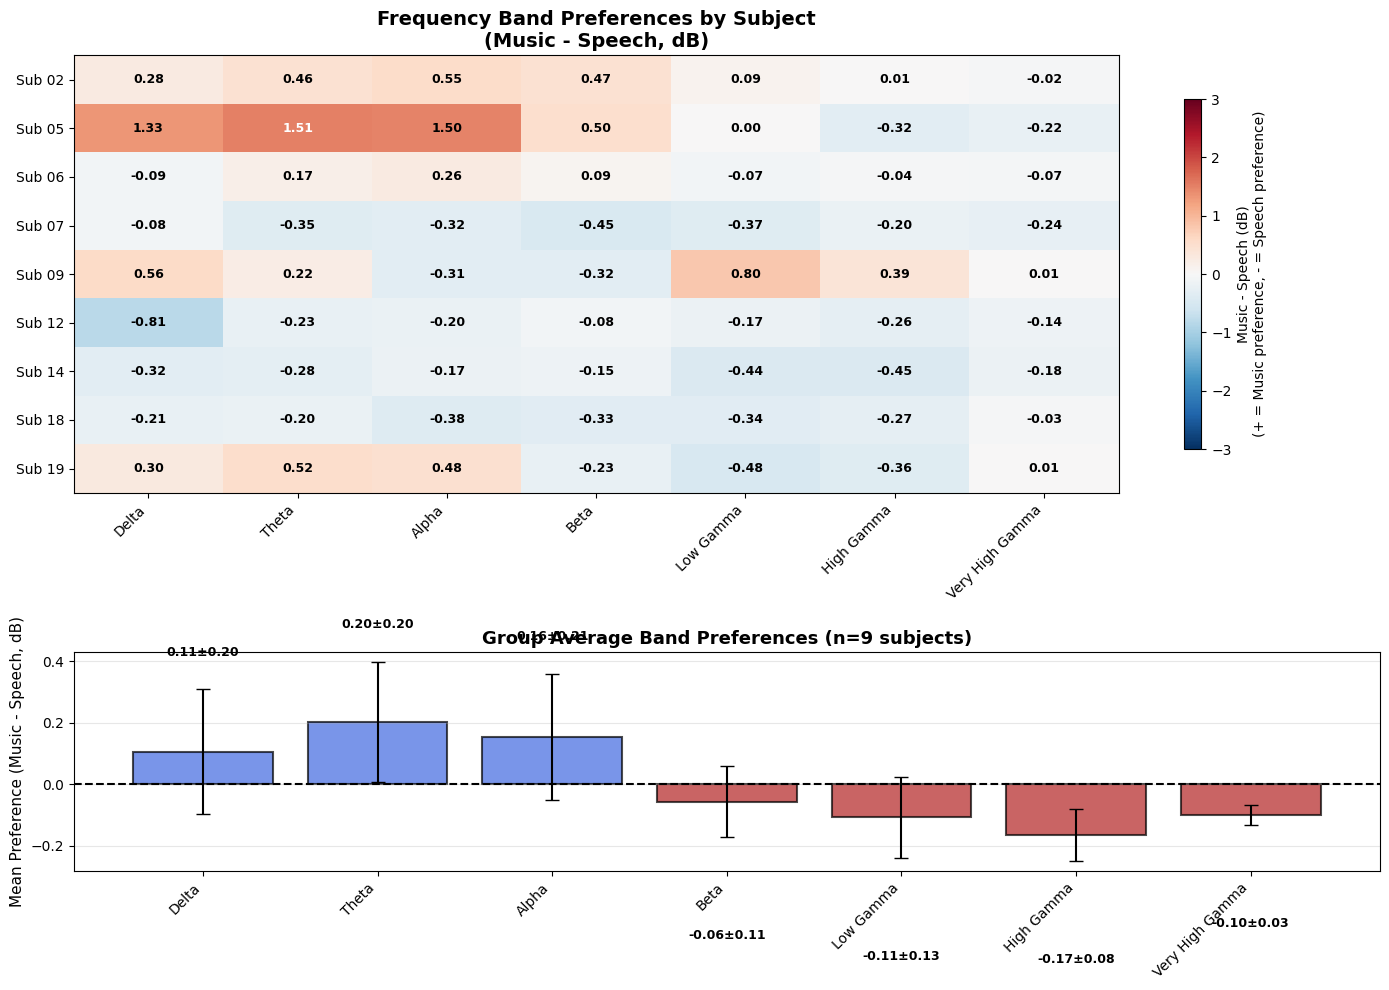


SUMMARY STATISTICS

Delta (1-4 Hz):
  Mean preference: +0.106 ± 0.202 dB → MUSIC
  4/9 subjects prefer Music
  5/9 subjects prefer Speech

Theta (4-8 Hz):
  Mean preference: +0.202 ± 0.196 dB → MUSIC
  5/9 subjects prefer Music
  4/9 subjects prefer Speech

Alpha (8-13 Hz):
  Mean preference: +0.155 ± 0.205 dB → MUSIC
  4/9 subjects prefer Music
  5/9 subjects prefer Speech

Beta (13-30 Hz):
  Mean preference: -0.057 ± 0.114 dB → SPEECH
  3/9 subjects prefer Music
  6/9 subjects prefer Speech

Low Gamma (30-70 Hz):
  Mean preference: -0.107 ± 0.132 dB → SPEECH
  3/9 subjects prefer Music
  6/9 subjects prefer Speech

High Gamma (70-150 Hz):
  Mean preference: -0.165 ± 0.085 dB → SPEECH
  2/9 subjects prefer Music
  7/9 subjects prefer Speech

Very High Gamma (150-250 Hz):
  Mean preference: -0.099 ± 0.033 dB → SPEECH
  2/9 subjects prefer Music
  7/9 subjects prefer Speech

LOW vs HIGH FREQUENCY TREND
Low frequencies (1-13 Hz) average: +0.154 dB
High frequencies (30-250 Hz) average: -

In [ ]:
import pandas as pd


# Define frequency bands
freq_bands = {
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-13 Hz)': (8, 13),
    'Beta (13-30 Hz)': (13, 30),
    'Low Gamma (30-70 Hz)': (30, 70),
    'High Gamma (70-150 Hz)': (70, 150),
    'Very High Gamma (150-250 Hz)': (150, 250)
}

# Calculate band preferences for each subject
band_preferences_all = {}

for sub_id, data in subjects_psd_data.items():
    f = data['frequencies']
    
    # Convert to log10 power (dB scale)
    music_log = 10 * np.log10(np.maximum(data['music_psd_raw'], 1e-30))
    speech_log = 10 * np.log10(np.maximum(data['speech_psd_raw'], 1e-30))
    
    # Calculate difference: Music - Speech (positive = music preference)
    diff_log = music_log - speech_log
    
    # Calculate mean difference for each frequency band
    band_prefs = {}
    for band_name, (fmin, fmax) in freq_bands.items():
        band_mask = (f >= fmin) & (f <= fmax)
        if band_mask.sum() > 0:
            band_prefs[band_name] = np.mean(diff_log[band_mask])
        else:
            band_prefs[band_name] = np.nan
    
    band_preferences_all[sub_id] = band_prefs

# Convert to DataFrame for easier visualization
band_prefs_df = pd.DataFrame(band_preferences_all).T
band_prefs_df.index.name = 'Subject'

print("=" * 80)
print("FREQUENCY BAND PREFERENCES: Music - Speech (dB)")
print("Positive values = Music preference | Negative values = Speech preference")
print("=" * 80)
print(band_prefs_df.round(3))


fig, axes = plt.subplots(2, 1, figsize=(14, 10), 
                         gridspec_kw={'height_ratios': [2, 1]})

# --- Panel 1: Heatmap of all subjects ---
ax1 = axes[0]
band_names_short = [b.split(' (')[0] for b in freq_bands.keys()]
vmax = max(3, np.abs(band_prefs_df.values).max())

im = ax1.imshow(band_prefs_df.values, aspect='auto', cmap='RdBu_r',
                vmin=-vmax, vmax=vmax, interpolation='nearest')

ax1.set_yticks(range(len(band_prefs_df)))
ax1.set_yticklabels([f'Sub {s}' for s in band_prefs_df.index])
ax1.set_xticks(range(len(band_names_short)))
ax1.set_xticklabels(band_names_short, rotation=45, ha='right')
ax1.set_title('Frequency Band Preferences by Subject\n(Music - Speech, dB)', 
              fontsize=14, fontweight='bold')

# Add value annotations
for i in range(len(band_prefs_df)):
    for j in range(len(band_names_short)):
        val = band_prefs_df.values[i, j]
        if not np.isnan(val):
            text_color = 'white' if abs(val) > vmax * 0.5 else 'black'
            ax1.text(j, i, f'{val:.2f}', ha='center', va='center',
                    color=text_color, fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
cbar.set_label('Music - Speech (dB)\n(+ = Music preference, - = Speech preference)', 
               fontsize=10)

# --- Panel 2: Group average with error bars ---
ax2 = axes[1]
band_means = band_prefs_df.mean(axis=0)
band_sems = band_prefs_df.sem(axis=0)

x_pos = np.arange(len(band_names_short))
colors = ['royalblue' if m > 0 else 'firebrick' for m in band_means]

bars = ax2.bar(x_pos, band_means, yerr=band_sems, color=colors, alpha=0.7,
               edgecolor='black', linewidth=1.5, capsize=5)

ax2.axhline(0, color='black', linewidth=1.5, linestyle='--')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(band_names_short, rotation=45, ha='right')
ax2.set_ylabel('Mean Preference (Music - Speech, dB)', fontsize=11)
ax2.set_title(f'Group Average Band Preferences (n={len(band_prefs_df)} subjects)', 
              fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, mean_val, sem_val) in enumerate(zip(bars, band_means, band_sems)):
    height = bar.get_height()
    label_y = height + sem_val + 0.1 if height > 0 else height - sem_val - 0.3
    ax2.text(bar.get_x() + bar.get_width()/2, label_y,
            f'{mean_val:.2f}±{sem_val:.2f}',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('band_preferences_music_vs_speech.png', dpi=150, bbox_inches='tight')
plt.show()


print("\n" + "=" * 80)
print("SUMMARY STATISTICS")
print("=" * 80)

for band_name in freq_bands.keys():
    mean_pref = band_prefs_df[band_name].mean()
    sem_pref = band_prefs_df[band_name].sem()
    
    # Count subjects with music vs speech preference
    n_music = (band_prefs_df[band_name] > 0).sum()
    n_speech = (band_prefs_df[band_name] < 0).sum()
    
    preference = "MUSIC" if mean_pref > 0 else "SPEECH"
    
    print(f"\n{band_name}:")
    print(f"  Mean preference: {mean_pref:+.3f} ± {sem_pref:.3f} dB → {preference}")
    print(f"  {n_music}/{len(band_prefs_df)} subjects prefer Music")
    print(f"  {n_speech}/{len(band_prefs_df)} subjects prefer Speech")

# Test for low vs high frequency trend
low_freq_bands = ['Delta (1-4 Hz)', 'Theta (4-8 Hz)', 'Alpha (8-13 Hz)']
high_freq_bands = ['Low Gamma (30-70 Hz)', 'High Gamma (70-150 Hz)', 'Very High Gamma (150-250 Hz)']

low_freq_mean = band_prefs_df[low_freq_bands].mean(axis=1).mean()
high_freq_mean = band_prefs_df[high_freq_bands].mean(axis=1).mean()

print("\n" + "=" * 80)
print("LOW vs HIGH FREQUENCY TREND")
print("=" * 80)
print(f"Low frequencies (1-13 Hz) average: {low_freq_mean:+.3f} dB")
print(f"High frequencies (30-250 Hz) average: {high_freq_mean:+.3f} dB")
print(f"Difference (Low - High): {low_freq_mean - high_freq_mean:+.3f} dB")

if low_freq_mean > 0 and high_freq_mean < 0:
    print("\n✓ CONFIRMED: Music preference in LOW frequencies, Speech preference in HIGH frequencies")
elif low_freq_mean > high_freq_mean:
    print("\n✓ TREND DETECTED: Stronger music preference in low frequencies")
else:
    print("\n⚠ Pattern differs from expected low/high frequency split")